In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

import CHIRPS.reproducible as rp
from lore import lore
from lore import test_lore as tlore
from lore import prepare_dataset as prda
from lore import neighbor_generator as ng
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# project_dir = '/datadisk/whiteboxing/examples'
project_dir = 'V:\\whiteboxing\\examples' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\exampada'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
#mydata = dsp.usoc2(random_state=random_state_splits, project_dir=project_dir)
d_constructor = ds.adult_small_samp
mydata = d_constructor(random_state=random_state_splits, project_dir=project_dir)
meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build model, tuned for high accuracy
model = 'RandomForest'
# model = 'AdaBoost1'
# model = 'AdaBoost2'
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : False}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : None}) # defaults to n_trees [200, 400, ..., 1600]

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    stop # ValueError

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    # override_tuning=True,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

AttributeError: module 'bottleneck' has no attribute '__version__'

In [ ]:
# lore proprietary
# path_data = 'C:\\Users\\id126493\\Documents\\GitHub\\explain_te\\lore\\datasets\\'

# dataset = prepare_german_dataset('german_credit.csv', path_data)
# dataset = prda.prepare_compass_dataset('compas-scores-two-years.csv', path_data)

# dataset = prda.prepare_adult_dataset('adult.csv', path_data)
# tlore.main(dataset=dataset, path_data=path_data, blackbox=rf, log=False)

In [ ]:
instances, _ , instances_enc, instances_enc_matrix, labels = rp.unseen_data_prep(tt, n_instances=1)
instances.iloc[0]

In [ ]:
rule = [{'income': '<=50K'}, {'educationnum': '<=13'}, [542.0, 2.6]]

In [ ]:
lore_dataset = rp.lore_prepare_dataset(d_constructor.__name__, mydata, meta_data)
instances, _ , instances_enc, instances_enc_matrix, labels = rp.unseen_data_prep(tt,
                                                                                n_instances=1)
rule, counterfactuals, infos = rp.lore_explain(instances.iloc[0], X_train=tt.X_train,
                                               dataset=lore_dataset, blackbox=rf,
                                               log=False, random_state=random_state)

In [1]:
import io
import zipfile
import urllib
import numpy as np
import pandas as pd
from datetime import datetime
import math
import julian
import re
from sklearn.impute import SimpleImputer
import unicodedata
random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# for notebook plotting
%matplotlib inline 

In [51]:
random_state = 123
file = 'noshow.csv'
archive = zipfile.ZipFile('CHIRPS/source_datafiles/noshow.zip', 'r')
lines = archive.read(file).decode("utf-8").split('\r\n')
archive.close()

lines = [lines[i].replace(', ', ' - ').replace('"', '').
         replace('No-show', 'no_show').split(',') for i in range(len(lines))]
names = [nm for nm in lines[0]]
lines = lines[1:]
lines.pop() # empty final row
noshow = pd.DataFrame(lines, columns=names)

def unicodeMap(x):
    return(unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode())

def ageMap(x):
    if x == '-1':
        return(0)
    else:
        return(int(x))
    
noshow['Neighbourhood'] = noshow['Neighbourhood'].apply(unicodeMap)
noshow['Age'] = noshow['Age'].apply(ageMap)
noshow['SchedDay'] = pd.to_datetime(noshow.ScheduledDay).dt.day_name()
noshow['SchedMonth'] = pd.to_datetime(noshow.ScheduledDay).dt.month_name()
noshow['ApptDay'] = pd.to_datetime(noshow.AppointmentDay).dt.day_name()
noshow['ApptMonth'] = pd.to_datetime(noshow.AppointmentDay).dt.month_name()

# get a date difference between booking and appointment
noshow['LagDays'] = pd.to_datetime(noshow.AppointmentDay) - pd.to_datetime(noshow.ScheduledDay)
noshow.LagDays.loc[(pd.to_datetime(noshow.AppointmentDay) - pd.to_datetime(noshow.ScheduledDay)) < \
                   (pd.to_datetime(1) - pd.to_datetime(1))] = pd.to_datetime(1) - pd.to_datetime(1)
noshow.LagDays = noshow.LagDays / pd.to_timedelta(1, unit='D') # convert to float of days
noshow.drop(columns=['PatientId', 'AppointmentID' , 'ScheduledDay', 'AppointmentDay'], inplace=True)
var_names = noshow.columns.to_list()
var_names = [vn for vn in var_names if vn != 'no_show']
var_names.append('no_show')
noshow = noshow[var_names] # put the class col at the end
noshow.to_csv('CHIRPS\\datafiles\\noshow.csv.gz', index=False, compression='gzip')
samp = noshow.sample(frac=0.2, random_state=random_state)
samp.reset_index(drop=True, inplace=True)
samp.to_csv('CHIRPS\\datafiles\\noshow_samp.csv.gz', index=False, compression='gzip')
small_samp = noshow.sample(frac=0.02, random_state=random_state)
small_samp.reset_index(drop=True, inplace=True)
small_samp.to_csv('CHIRPS\\datafiles\\noshow_small_samp.csv.gz', index=False, compression='gzip')

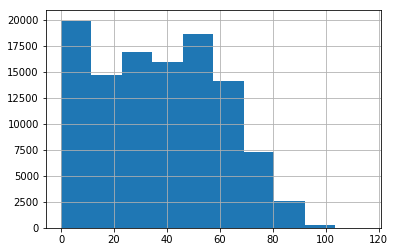

In [50]:
noshow.Age.hist()

In [2]:
x = [[[136.0, 0.001710863986313088, 0.08822062895957186, 0.007853403141361256, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 138.0, 140.0, 146.88771223385496, 2.0, 0.0], [136.0, 0.014906832298136647, 0.0, 0.003569446391968336, 0.0043099796198929315, -9.448157598333983e-05, 0.0, 20.46156859745384, 1.5, 0.0, 11.2, 111.0, 68.59905191717274, 185.0, 11.0, 0.0, 140.0, 140.0, 150.45487038279035, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.006947117500379643, -0.0002193254009438541, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.709319229525491], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -0.00011138671238407493, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 132.20419112964728, 112.0, 151.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.01501251042535446, 0.005025125628140704, 0.0, -0.0001029365907072054, -0.0002112114703921444, 24.0, 1.2, 0.0, 11.2, 69.0, 136.0, 185.0, 3.0, 0.0, 142.0, 150.0, 146.6724197774117, 44.446175898513246, -0.18567864909676896], [134.00447029127628, 0.005282015052456767, 0.0, 0.0006754881986846795, 0.0010647658047636395, 0.0, 0.0, 17.68738053369175, 0.2, 0.0, 11.2, 111.0, 91.18560009774365, 185.0, 11.0, 0.0, 132.20419112964728, 112.0, 151.0, 2.0, 0.5784445444191804], [135.27086386889994, 0.002512562814070352, 0.0, 0.002331002331002331, 0.0004440827135019311, 0.0, 0.0009998646525355924, 70.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 2.7873521333926305, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [144.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 22.35166277273542, 1.5, 0.0, 4.189447007995408, 111.0, 74.0, 149.23770666040758, 11.0, 0.0, 140.0, 149.0, 141.0, 34.38321575259357, 0.0], [144.0, -4.661777895442884e-05, 0.0, 0.003105590062111801, 0.0, 0.0, 0.0, 52.0, 1.8, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 161.0, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.005025125628140704, 0.0, -4.806028527340548e-06, 0.0, 51.76010197949388, 1.5, 0.0, 12.316171880113364, 83.08838863482882, 74.0, 185.0, 11.0, -0.12153039048709213, 149.9336683992582, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.002827521206409048, 0.0, -6.828556465675065e-05, 0.0, 29.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.004748983174179539, 0.002103648754629134, 0.01188118811881188, 0.0, 0.0, 24.0, 2.2829344766605266, 1.0, 11.2, 39.0, 79.94484885733922, 175.0, 11.0, 0.0, 163.0, 122.60483303652133, 141.0, 2.0, 1.4805485163554022], [136.0, 0.002512562814070352, -0.01841889247868549, 0.003627569528415962, 0.006821964569721889, 4.3511029010348666e-05, 0.0, 35.0, 1.5, 10.867078701420594, 11.2, 59.0, 74.0, 185.0, 2.9768790226775965, 1.0, 167.7132259412966, 140.0, 141.0, 2.0, 0.0], [136.0, 0.009015233094302112, 0.0, 0.005025125628140704, 0.0, -5.960431140712597e-05, 0.00023746296439127988, 24.0, 0.8, 22.94892474391565, 11.2, 21.94559202861459, 74.0, 185.0, 11.0, -0.15761762840916532, 140.0, 139.0, 141.0, 1.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, -0.0004955876973477773, 24.0, 1.7, 0.0, 11.2, 111.0, 127.0, 185.0, 11.0, -0.6187114133352768, 132.16499912494314, 140.0, 141.0, 42.97143347144855, 0.4388825304706653], [136.0, 0.002512562814070352, 0.0, 0.003230809519432446, 0.0, 0.0, 0.0, 62.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 79.94484885733922, 195.25461453419007, 7.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [120.76099337677759, 0.0, 0.0, 0.010917030567685587, 0.0009861932938856016, 0.0, 0.0, 24.0, 3.2, 0.0, 11.2, 111.0, 74.0, 185.0, 4.623462638910351, 0.0, 108.0, 140.0, 113.0, 2.0, -1.237006895301867], [136.0, 0.0012150293879458155, 0.0, 0.002331002331002331, 0.0004440827135019311, 0.0, 0.0009998646525355924, 70.0, 1.5, 0.0, 11.2, 111.0, 69.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [150.0, 0.002512562814070352, 0.0, 0.004842615012106539, 0.0, 0.0, 0.0, 80.0, 1.5, 0.0, 11.2, -36.21366612940629, 129.0, 133.0, 5.492243994824476, 0.0, 140.0, 111.1483536381938, 141.0, 3.0, -1.0], [122.0, 0.006214845687279299, 0.0, 0.0, 0.0, 0.0, -0.00045225858085362733, 24.0, 2.3, 0.0, 6.540755062500991, 91.0, 78.523372885485, 165.4256052372111, 3.0, 0.0, 136.0, 140.0, 134.39680089114506, 22.801892735684888, 0.0], [147.7860674875546, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.5349145747493824], [150.0, 0.002512562814070352, 0.0, 0.004842615012106539, 0.0, 0.0, 0.0, 80.0, 1.5, 0.0, 6.540755062500991, -36.21366612940629, 129.0, 133.0, 5.492243994824476, 0.0, 140.0, 111.1483536381938, 141.0, 3.0, -1.0], [131.0, 0.006509057408347167, -0.03369056942673261, 0.004329004329004329, -0.001528482467214351, -6.828556465675065e-05, 0.0, 24.0, 2.3, 0.0, 12.0, 111.0, 74.0, 129.1255175646945, 2.6820444586405277, 0.0, 140.0, 147.85861274489963, 141.0, 75.0, 0.0], [130.0, 0.002512562814070352, -0.015768065788348353, 0.002827521206409048, 0.0, -6.828556465675065e-05, 0.0, 24.0, 1.1, 16.0, 11.2, 111.0, 121.0, 185.0, 1.0, 0.0, 142.0, 150.0, 141.0, 2.0, 0.0], [133.0, 0.0030786995574969816, 0.0, 0.005513824624197743, 0.0, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 3.1155784923164997, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 92.67621592767803, 74.0, 144.59618269025304, 11.0, 0.0, 142.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.007853403141361256, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.014906832298136647, 0.0, 0.0045620437956204385, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 80.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.007716049382716048, 0.008996521875760336, 2.9079184097246916e-06, 0.0, 17.0, 0.7, 17.87006241876383, 15.5, 33.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [135.87617436505408, 0.003389830508474576, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, -9.056843040801809, 11.2, 111.0, 68.0, 185.0, 3.9728324955226006, 0.0, 150.0, 140.0, 141.0, 2.0, 1.4204349530932614], [149.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.00112943658499558, 0.0, 0.0, 24.0, 1.5, 0.0, 1.2493439457713578, 19.0, 120.0, 172.1673922156058, 11.0, 0.0, 157.34250681430808, 137.35818458899956, 141.0, 2.0774691932235925, 0.0], [136.0, 0.002512562814070352, 0.001226993865030675, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 19.579993782596937, 11.2, 111.0, 65.0, 185.0, 11.0, 1.087421860523913, 132.16499912494314, 118.41256539430876, 141.0, -9.516700855951306, 0.8867550809750316], [136.0, 0.008791208791208791, -0.09163815305228498, 0.0015838352193256956, 0.0016863406408094436, 7.440761733597465e-05, 0.0, 24.0, 1.5, 0.0, 6.571784688880675, 111.0, 102.0, 154.69128457518286, 0.0, 0.0, 140.0, 140.0, 139.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.004157692848014201, 0.003478958029981859, 0.0, 0.0, 0.0, 24.0, 1.5, 5.029076197691863, -0.5191110015528668, 136.0, 74.0, 134.67823660586674, 11.0, -0.15761762840916532, 140.0, 131.38027748934522, 141.0, 2.0, 0.9748680423533359], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 32.0, 1.5, -8.092968131845613, 11.2, 111.0, 74.0, 185.0, 3.140621346852959, 0.0, 140.0, 140.0, 141.0, 53.0, 0.0], [136.0, 0.014906832298136647, 0.0, 0.007853403141361256, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 140.0, 131.0, 146.88771223385496, 2.0, 0.0], [136.0, 0.002512562814070352, 0.004790419161676647, 0.005025125628140704, 0.0, 0.0, 0.0, 20.0, 1.7, 27.02863053364185, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 137.77974297458647, 123.15110907329023, 2.0, 0.6975398584304725], [140.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -4.806028527340548e-06, 0.0, 40.00704382119607, 1.5, 0.0, 19.191720514952266, 13.0, 74.0, 167.2286328945329, 11.0, 0.0, 136.0, 140.0, 123.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.004542550832780659, 0.0, 0.0, 61.69845207657711, 1.5, 2.373734445446308, 6.3, 111.0, 49.087108744746274, 185.0, 11.0, 0.6892950446537434, 140.0, 140.0, 158.0, 6.0, 0.0], [133.0, 0.0030786995574969816, 0.0, 0.005513824624197743, 0.0, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 92.67621592767803, 74.0, 144.59618269025304, 11.0, 0.0, 142.0, 140.0, 141.0, 3.1155784923164997, 0.0], [136.0, -0.000740791450526235, 0.0, 0.005025125628140704, 0.0026809651474530827, 2.8559763062908316e-05, 0.00048075762030965445, 24.0, 1.5, 0.0, 1.1, 28.0, 74.0, 185.0, 11.0, 0.0, 136.0, 140.0, 141.0, 58.60660884020186, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0046124408796784505, 0.0, 0.0, 0.0, 24.0, 1.5, 27.492102337208575, 11.2, 111.0, 74.0, 155.53437930542543, 11.0, 0.0, 144.0, 140.0, 141.0, 40.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.003374578177727784, 0.0, 0.0015479876160990713, 55.507312588064906, 1.5, 0.0, 8.4, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0001285656941184567, 24.0, 1.683965413906761, 0.0, 11.2, 111.0, 74.0, 185.0, 2.9014348492387225, 0.0, 153.0, 138.0, 141.0, 22.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 79.94484885733922, 177.8115654739205, 11.0, 0.0, 188.855923831466, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 33.0, 1.5, -26.36072603395621, 11.2, 111.0, 92.69287430678416, 185.0, 11.0, 1.0, 127.0, 147.85861274489963, 141.0, 2.0, -0.18219857242794452], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 46.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [132.11045847391227, 0.002512562814070352, 0.0, 0.005025125628140704, 0.004305130545090882, 0.0, -0.000483751540404283, 24.0, 1.5, 0.0, 7.0, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 143.0, 2.0, 0.0], [131.82321298157092, 0.0, 0.0, 0.005025125628140704, 0.003388612348091161, 0.0, 0.0, 24.0, 2.4, 0.0, 5.5, 81.34387012358455, 74.0, 156.57398113920883, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 9.8, 111.0, 74.0, 185.0, 1.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 3.2382541783620364e-05, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 138.0, 140.0, 141.0, 2.0, -0.767599737611021], [136.0, 0.002512562814070352, 0.07339146397302727, 0.005025125628140704, 0.00446064068024628, 0.0, 0.0008901252288457209, 24.0, 1.5, 0.0, 9.234829986095201, 111.0, 74.0, 185.0, 5.167239792884116, 0.0, 137.0, 138.58250621245517, 160.3963117811171, 2.0, 0.0], [135.97499738866313, 0.002512562814070352, 0.0, 0.002309866450348772, 0.0, 0.0, 0.0012610340479192938, 30.83904556768152, 4.2, 0.0, 8.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [126.76390394858686, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 41.0, 0.3, 0.0, 18.4, 111.0, 94.2778258226288, 163.44726750782658, 1.0, 0.6892950446537434, 141.0, 140.0, 141.0, 2.0, 0.0], [128.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 138.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.767599737611021], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00020051416369766184, 24.0, 1.5, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, 0.0, 155.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.0012150293879458155, 0.0, 0.005457025920873124, 0.006055621195605849, 0.0, 0.0, 24.0, 0.9316737891186702, 0.0, 11.2, 111.0, 130.66248198103446, 142.74446015779262, 3.0, 0.0, 129.0, 141.16922176053967, 138.0, 2.0, 0.0], [136.0, 0.0036657652820047946, 0.0, 0.009708737864077669, 0.0, 0.0, 0.0, 24.0, 3.097231601292268, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 127.0, 80.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, -13.043716849371648, 11.2, 111.0, 120.0, 185.0, 3.889858351387402, 0.0, 111.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.9, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0013079000327017704, 0.0, 0.0029201527263522133, 0.0, 0.0, 0.0, 24.0, 0.7, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [125.0, 0.006659779892422963, 0.0, 0.007263922518159807, -0.002892748801580162, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 23.0, 120.0, 185.0, 11.0, 0.0, 108.47291084946671, 140.0, 152.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.007468422861444287, 0.0, 5.6802820532188537e-05, 0.0, 24.0, 0.9849837698516486, 0.0, 14.128147200482694, 90.37659887473004, 109.23238133461498, 185.0, 5.884579928995519, 0.0, 138.0, 109.82348738358276, 123.48329674458871, -8.681209666363191, 0.0], [136.0, -0.0031288743849808517, 0.024844720496894408, 0.005025125628140704, 0.0, 0.0, 0.0, 58.92428220005092, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.5349145747493824], [147.7860674875546, 0.002512562814070352, 0.050279051927937385, 0.0071428571428571435, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 84.02645653471166, 74.0, 151.74308852811407, 0.8596881584502394, 0.0, 145.15982512356322, 140.0, 141.0, 24.226480988802365, 0.0], [122.0, 0.0032587841526543937, 0.0, 0.0042403828424428976, 0.0, 2.702636318249687e-05, 0.0, 33.0, 1.5, 0.0, 11.2, 111.0, 97.93323072718997, 166.24239227553164, 5.0, 0.0, 138.0, 164.0, 141.0, 3.1155784923164997, 0.0], [112.11083053308352, 0.002512562814070352, -0.03369056942673261, 0.004329004329004329, 0.0, -6.828556465675065e-05, 0.0, 24.0, 1.1, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.7345347637888023, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 153.0, 92.69287430678416, 185.0, 10.493204526953981, 0.0, 155.0, 140.0, 145.0, 2.0, 0.5740811925670541], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, -26.36072603395621, 11.2, 84.80347180032369, 74.0, 182.14097474359656, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [139.42897469924526, 0.0011363636363636365, 0.01501251042535446, -0.002415162116639815, 0.0, -0.0001029365907072054, -0.0002112114703921444, 57.265381469664646, 0.7, 0.0, 11.2, 109.49886778817861, 74.0, 168.52179721835884, 4.8937688754355495, 1.0, 155.0, 150.0, 126.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003983797290401213, 0.0, 0.0, 0.0, 34.84157596947017, 0.4, 0.0, 12.316171880113364, 83.08838863482882, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 146.6724197774117, 2.7103551015508476, 0.0], [148.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 3.799974971428096e-05, 6.6018447136701255, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 163.27735896885073, 140.0, 141.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 79.94484885733922, 177.8115654739205, 11.0, 1.0, 127.0, 147.85861274489963, 141.0, 2.0, 0.0], [149.0, -0.0017602200604517212, 0.0, 0.0029201527263522133, 0.0, 0.0, 5.127906547813528e-05, 24.0, 0.3, 0.0, 11.2, 111.0, 74.0, 185.0, 6.0, 0.0, 105.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002798507462686567, 0.0, 0.005025125628140704, -0.0015497650365261112, 0.0, -0.00018032057977502067, 56.0, 1.5, 0.0, 7.3, 109.57636717543414, 74.0, 173.0, 5.0, 0.0, 140.0, 133.52369325614103, 118.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.035937821559252306, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.5, 22.94892474391565, 7.9, 111.0, 91.24408862649769, 185.0, 0.14815284033619136, 0.0, 140.0, 140.0, 154.0, -13.77517985591972, 0.0], [136.0, 0.0014691365934957402, -0.0180050141596488, 0.003478260869565217, 0.0, 0.0, 0.001119111114227021, 24.0, 1.3, 0.0, 4.8, 109.0, 74.0, 185.0, 11.0, -0.15761762840916532, 140.0, 147.0, 141.0, 16.598523932785522, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0023594361629103934, 0.0, 0.0, 0.0, 24.0, 1.5, 16.004166482526806, 12.6, 111.0, 74.0, 149.8460523834502, 11.0, 1.0, 140.0, 155.0, 141.0, 2.0, 1.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [130.0, 0.002512562814070352, -0.015768065788348353, 0.002827521206409048, 0.0, 7.759333233992874e-05, 0.0, 24.0, 1.9, 34.3338444575693, 11.3, 111.0, 74.0, 185.0, 11.0, 0.0, 96.6032314903336, 140.0, 121.27266358679186, 2.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 32.0, 1.5, -8.092968131845613, 11.2, 111.0, 74.0, 185.0, 3.140621346852959, 0.0, 140.0, 140.0, 141.0, 53.0, 0.0], [136.0, 0.002798507462686567, 0.0, 0.005025125628140704, -0.0015497650365261112, 0.0, 0.0, 24.0, 1.09207050550856, 16.0, 11.3, 128.0, 74.0, 185.0, 11.0, 0.0, 151.4073885864847, 140.0, 141.0, 77.0, 0.0], [130.0, 0.002512562814070352, -0.015768065788348353, 0.002827521206409048, 0.0012484394506866415, -6.828556465675065e-05, 0.0, 66.0, 2.148349438102968, 0.2925424674890955, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 114.72866850465098, 141.0, 2.0, 0.0], [138.0, 0.0022556929777397417, -0.03350490053314705, 0.005025125628140704, 0.00011106726134721542, 0.0, 0.0001559760394908212, 61.0, 0.4, 34.53618522667125, 11.2, 111.0, 117.0, 180.42035089779404, 11.0, 0.0, 133.33060194668718, 140.0, 138.16809704246094, 2.7103551015508476, 0.0], [135.87617436505408, 0.003389830508474576, 0.0, 0.007716049382716048, 0.008996521875760336, 2.9079184097246916e-06, 0.0001640976950802334, 53.69653132599906, 0.4, 17.87006241876383, 15.5, 33.0, 68.0, 184.90463194430785, 3.9728324955226006, 0.0, 123.0, 140.0, 141.0, 31.0, 1.4204349530932614], [112.11083053308352, 0.002512562814070352, -0.03369056942673261, 0.004329004329004329, 0.0, -6.828556465675065e-05, 0.0, 24.0, 1.1, 16.0, 11.2, 111.0, 121.0, 185.0, 1.0, 0.0, 142.0, 150.0, 141.0, 2.0, 0.0], [129.2941309788459, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00034112280591314613, 25.639342464362542, 1.0686168358632262, 0.0, 7.4, 111.0, 87.0, 187.01149408222884, 3.0996336881754782, 0.5779582107974854, 140.0, 102.81209835874667, 145.0, 30.002131508572297, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 110.0, 150.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [131.0, 0.002512562814070352, -0.022544604073227673, 0.005025125628140704, 0.0039223919717096285, 0.0, 0.0008282186562255171, 22.35166277273542, 1.5, 8.0, 11.2, 14.626946451254014, 50.0, 185.0, 11.0, 2.7010424221839306, 126.0, 140.0, 108.37563708202676, 34.38321575259357, 0.0], [136.0, 0.002512562814070352, 0.001226993865030675, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 19.579993782596937, 11.2, 111.0, 65.0, 185.0, 11.0, 1.087421860523913, 132.16499912494314, 118.41256539430876, 141.0, -9.516700855951306, 0.8867550809750316], [135.87617436505408, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0002993994143040274, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 161.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.012276785714285714, 3.0263617821113396e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 52.0, 185.0, 11.0, 0.0, 129.21841528692238, 140.0, 141.0, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.006947117500379643, -0.0002193254009438541, -0.00011138671238407493, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.709319229525491], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0065886081405345165, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.9, 17.27768474017283, 5.4485929792984855, 111.0, 74.0, 185.0, 11.0, 0.0, 114.81392201899803, 141.0726396186761, 141.0, 2.0, 0.004646489593046699], [128.0, 0.002512562814070352, 0.009111617312072893, 0.008291873963515755, 0.002737595502937241, -5.170710201317124e-05, 0.0, 55.0, 1.5, 0.0, 2.926097574813949, 8.00290437381588, 74.0, 185.0, 6.0, 0.0, 164.00945449446095, 136.0, 141.0, 2.0, 0.12642153932715913], [136.0, 0.002512562814070352, 0.0, 0.0011098779134295226, 0.0, 0.0, 0.0, 60.0, 1.5, 0.0, 11.2, 111.0, 121.0, 185.0, 3.9728324955226006, 0.0, 140.0, 123.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, 0.0, 155.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.015351259807430559, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 129.0, 141.0, 2.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 30.0, 11.2, 111.0, 74.0, 146.0, 5.0, 0.0, 140.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 46.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0041841004184100415, 0.0, -0.0011902956174210282, 24.0, 1.8, 0.0, 11.2, 111.0, 74.0, 238.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.4167685283808401], [136.0, 0.002512562814070352, 0.06126952297071573, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 7.367031087860342, 111.0, 74.0, 185.0, 7.0, 0.0, 140.0, 140.0, 141.0, 3.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 2.4, 0.0, 11.2, 111.0, 152.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.0], [131.82321298157092, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 5.5, 111.0, 74.0, 179.90663698804144, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -1.955468535996584e-05, 0.0, 24.0, 1.2044193987887752, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 126.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003983797290401213, 0.0, 0.0, 0.0, 34.84157596947017, 0.4, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 1.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 45.0, 1.5, 0.0, 11.2, 111.0, 64.49412659615794, 185.0, 11.0, 0.0, 140.0, 145.0, 125.0, 2.0, 0.0], [135.27086386889994, 0.002512562814070352, 0.0, 0.002331002331002331, 0.0004440827135019311, 0.0, 0.0009998646525355924, 62.0, 1.5, 33.0, 11.2, 111.0, 62.96836852860321, 160.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.04874006605648428, 0.005025125628140704, 0.0016863406408094436, 0.0, 0.0, 24.0, 0.8, -12.912832772798431, 11.2, 2.684877629228339, 74.0, 185.0, 11.0, 0.20813366225709223, 140.0, 155.9854938218741, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.015768065788348353, 0.002827521206409048, 0.0012484394506866415, -6.828556465675065e-05, 0.0, 24.0, 1.5, 33.0, 11.2, 111.0, 62.96836852860321, 185.0, 11.0, 1.0, 132.23339880103225, 140.0, 141.0, 2.0, 0.0], [130.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.5, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 147.85861274489963, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.00737100737100737, 0.0, 5.085622438502836e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 153.57946369354306, 7.0, 0.0, 140.0, 152.82913044253468, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0011098779134295226, 0.002737595502937241, -5.170710201317124e-05, 0.0, 55.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 3.9728324955226006, 0.0, 140.0, 123.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.06126952297071573, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 7.367031087860342, 111.0, 74.0, 185.0, 7.0, 0.0, 140.0, 140.0, 141.0, 3.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 5.5, 111.0, 74.0, 179.90663698804144, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 92.67621592767803, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.002827521206409048, 0.0, -6.828556465675065e-05, 0.00048075762030965445, 50.863364786315486, 1.2569456069211784, 0.0, 1.1, 28.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 64.49412659615794, 185.0, 11.0, 0.0, 140.0, 145.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 69.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 89.0, 74.0, 189.0, -2.7400919927089156, 1.0, 127.0, 132.6919329440545, 141.0, -31.575820035498378, 1.3085177051781418], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, 0.0, 24.0, 1.1828010372133444, 0.0, 11.2, 111.0, 79.94484885733922, 177.8115654739205, 11.0, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003983797290401213, 0.0, 0.0, 0.0, 24.0, 1.5, 30.015467480955568, 1.1, 28.0, 74.0, 185.0, 11.0, 1.0, 148.0, 141.0, 152.0392041129895, 2.7103551015508476, 0.0], [136.0, 0.010282776349614395, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 34.84157596947017, 0.4, 0.0, 11.2, 111.0, 113.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 10.80523902966401, 0.0], [136.0, -0.0031288743849808517, 0.024844720496894408, 0.0011098779134295226, 0.002737595502937241, -5.170710201317124e-05, 0.0, 55.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 3.9728324955226006, 0.0, 140.0, 123.0, 141.0, 24.226480988802365, 0.0], [136.0, 0.002512562814070352, 0.0, 0.006756098093659705, 0.0, 0.0, 0.00020491405901163455, 24.0, 1.5, 10.0, 0.3544521099564486, 111.0, 74.0, 185.0, -1.8512528219753683, 0.0, 140.0, 140.0, 141.0, 73.0, 0.0], [136.0, 0.001710863986313088, 0.08822062895957186, 0.003569446391968336, 0.0043099796198929315, -9.448157598333983e-05, 0.0, 20.46156859745384, 1.5, 0.0, 11.2, 111.0, 91.18560009774365, 153.0, 11.0, 0.0, 140.0, 140.0, 150.45487038279035, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 7.3, 111.0, 74.0, 168.52179721835884, 4.8937688754355495, 0.0, 140.0, 153.0, 141.0, 2.0, 0.0], [136.0, 0.00193059651304855, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 100.05915796588823, 78.3337032123155, 172.94495513030964, 1.0, 0.0, 140.0, 123.48949416349213, 141.0, 2.0, 0.0], [136.0, 0.00838070660921957, 0.0, 0.005025125628140704, 0.0005386665822903508, 0.0, 0.0, 24.0, 1.5, 0.0, 1.5083176680514656, 111.0, 74.0, 153.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0020535929237708865, 0.0, 0.005025125628140704, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 17.0, 71.0, 185.0, -0.5184297995208142, 0.0, 140.0, 140.0, 121.97801982050528, 2.0, 0.34065491456949215], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.006380601653868537, 0.0, 0.0007057372875877328, -0.0007300924104454195, 0.0, 0.0, 24.0, 1.5, 16.800775122818077, 11.2, 111.0, 74.0, 185.0, 3.434537051949898, 0.0, 147.0, 140.0, 137.0, 2.0, 0.0], [136.0, 0.005282015052456767, 0.0, 0.0006754881986846795, 0.0010647658047636395, 0.0, 0.0, 24.0, 0.2, 0.0, 11.2, 111.0, 68.59905191717274, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.18567864909676896], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.000722866812428508, 23.0, 1.5, 29.704577023493343, 11.2, 111.0, 74.0, 144.0, 4.428828295637908, 0.0, 140.0, 137.0, 141.0, 22.0, 0.0], [144.0, -4.661777895442884e-05, 0.0, 0.003105590062111801, 0.0, -4.806028527340548e-06, 0.0, 51.76010197949388, 3.5, 0.0, 6.8, 83.08838863482882, 74.0, 185.0, 11.0, -0.12153039048709213, 149.9336683992582, 140.0, 161.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0001285656941184567, 55.507312588064906, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 2.9014348492387225, 0.0, 153.0, 138.0, 141.0, 22.0, 0.0], [126.76390394858686, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 41.0, 0.3, 0.0, 18.4, 111.0, 94.2778258226288, 163.44726750782658, 1.0, 0.6892950446537434, 141.0, 140.0, 141.0, 2.0, 0.0], [123.53990956067392, 0.0014691365934957402, 0.05210414312938141, 0.003478260869565217, 0.0, 0.0, 0.0, 24.0, 0.5, 8.0, 7.9, 111.0, 91.24408862649769, 185.0, 0.14815284033619136, 0.48151734886249126, 145.0, 147.0, 141.0, -13.009676970021292, 0.0], [136.0, -0.0031288743849808517, 0.024844720496894408, 0.0011098779134295226, 0.002737595502937241, -5.170710201317124e-05, 0.0, 55.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 11.0, 0.0, 149.0597223439626, 140.0, 141.0, 24.226480988802365, -1.0], [137.26429597431945, 0.002512562814070352, 0.0, 0.004065845444009522, 0.0, 0.0, 0.0, 46.0, 1.5, 0.0, 11.2, 51.070398895041066, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0037677763851472435, 0.005025125628140704, 0.0, 0.0, 0.0009188492495584967, 24.0, 1.5, 0.0, 11.2, 111.0, 52.0, 130.0, 11.0, 1.0, 129.0, 137.49485175658614, 145.0, 21.564439987530633, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 60.0, 1.5, 4.2631940039077465, 11.2, 21.114979388473643, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0017241379310344827, 0.002958579881656805, 0.0, 0.0, 0.0, 72.74422390257689, 1.6, 0.0, 11.2, 111.0, 74.0, 185.0, 0.18581813650141665, 0.0, 140.0, 122.0, 141.0, 2.0, 0.0], [136.0, 0.014906832298136647, -0.06005240868039269, 0.001193046733498218, 0.0, 0.0, 0.0, 32.0, 6.3, 0.0, 8.4, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 138.0, 140.0, 146.88771223385496, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.007853403141361256, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 32.3381774757682, 79.94484885733922, 139.0, 1.0, 1.0, 172.52484933995407, 147.85861274489963, 141.0, 12.390438783269335, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00034112280591314613, 25.639342464362542, 1.5, 0.0, 7.4, 111.0, 96.0, 185.0, 11.0, 0.0, 140.0, 148.92185852082878, 141.0, 2.0, 0.0], [129.2941309788459, 0.002512562814070352, 0.0, 0.005025125628140704, -0.0013656879019908828, -6.167732705610213e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 3.0996336881754782, 0.5779582107974854, 140.0, 102.81209835874667, 157.54849411291863, 30.002131508572297, 0.0], [136.0, 0.002512562814070352, 0.0037677763851472435, 0.005025125628140704, 0.0, 0.0, 0.0009188492495584967, 24.0, 1.5, 0.0, 11.2, 111.0, 62.96836852860321, 160.0, 11.0, 1.018146028733649, 140.0, 140.0, 129.38920661737248, 2.0, 0.0], [135.27086386889994, 0.002512562814070352, 0.0, 0.002331002331002331, 0.0004440827135019311, 0.0, 0.0009998646525355924, 62.0, 1.5, 0.0, 11.2, 111.0, 52.0, 130.0, 11.0, 1.0, 129.0, 137.49485175658614, 145.0, 21.564439987530633, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003478260869565217, 0.0, 0.0, 0.0, 24.0, 1.5, 5.029076197691863, -0.5191110015528668, 136.0, 74.0, 134.67823660586674, 11.0, -0.15761762840916532, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 92.67621592767803, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, -0.002516547714278832, -0.04588201842119043, 0.0042105263157894745, 0.001744580802928736, 0.0, 0.0, 57.41461737555936, 1.5, 0.0, 11.2, 111.0, 122.85066314608973, 182.0, 3.0, 0.0, 145.05661689369026, 140.0, 141.0, 4.0, 0.0], [136.0, 0.0030786995574969816, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 57.0, 1.5, 0.0, 11.2, 100.05915796588823, 78.3337032123155, 172.94495513030964, 1.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.004048582995951417, 0.0, -0.0023474995524559936, 0.0, 0.0, 0.0, 19.204307734929618, 1.5, 0.0, 11.2, 3.687478441461238, 137.0, 151.2853510184799, 11.0, 0.1427755216712335, 140.0, 151.97067406435025, 130.0, 2.0, 0.0], [140.6405708888315, 0.006988632455763977, -0.002965137644514497, 0.008064516129032258, 0.0, 0.0, 0.0, 24.0, 1.9, 33.0, 11.2, 111.0, 62.96836852860321, 185.0, 11.0, 0.0, 140.0, 131.0, 146.88771223385496, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 62.0, 1.5, 33.0, 11.2, 111.0, 62.96836852860321, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [132.6417864695628, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 136.0, 141.0, 2.0, 0.0], [136.0, 0.0026385224274406327, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 2.386794359859383, 0.0, 6.7, 111.0, 64.49412659615794, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 66.0, 1.5, 0.0, 11.2, 109.57636717543414, 74.0, 185.0, -0.06527512703418648, 0.0, 138.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 160.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0001285656941184567, 55.507312588064906, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 2.9014348492387225, 0.0, 153.0, 138.0, 141.0, 22.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 17.0, 71.0, 185.0, -0.5184297995208142, 0.0, 140.0, 140.0, 121.97801982050528, 2.0, 0.34065491456949215], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 163.27735896885073, 140.0, 141.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, -0.03369056942673261, 0.002827521206409048, 0.0, -6.828556465675065e-05, 0.0, 24.0, 1.1, 16.0, 11.2, 111.0, 121.0, 185.0, 1.0, 0.0, 142.0, 150.0, 141.0, 2.0, 0.8059618477152133], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [141.0, 0.003389830508474576, 0.0, 0.002521459800315792, 0.009868421052631578, 0.0, 0.0, 60.0, 1.5, 0.0, 11.2, 109.0, 50.0, 185.0, 6.524386069336003, 0.0, 138.30969352465803, 140.0, 148.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.035937821559252306, 0.005025125628140704, 0.0, 0.0, 0.001119111114227021, 24.0, 1.3, 0.0, 11.2, 68.4710772009316, 99.82960322427476, 153.57946369354306, 7.0, 0.0, 140.0, 140.0, 117.0, 39.05530305111705, 0.0], [136.0, 0.008791208791208791, 0.0, 0.0015838352193256956, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 4.8, 109.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 154.0, -13.77517985591972, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.06005240868039269, 0.005025125628140704, 0.0, 1.3613247704715778e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 35.0, 74.0, 160.89842941715497, 11.0, 0.0, 156.0, 140.0, 141.0, 12.390438783269335, 0.0], [145.2493038686984, 0.0, 0.0, 0.002827521206409048, 0.0012484394506866415, -6.828556465675065e-05, 0.0, 24.0, 1.5, 0.0, 9.8, 111.0, 74.0, 185.0, 11.0, 1.0, 140.0, 155.0, 141.0, 2.0, -0.767599737611021], [140.0, 0.0020535929237708865, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 44.09242515117125, 11.2, 111.0, 74.0, 185.0, 11.0, 0.47810600434467604, 155.43907329492134, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.008559247286329341, 0.0, 0.0, 0.0005079410142084039, 20.0, 1.5, 0.0, 11.2, 111.0, 74.0, 197.0, 11.0, 0.7345347637888023, 117.63995538818185, 140.0, 141.0, 2.0, 0.0], [150.0, 0.002512562814070352, 0.0, 0.004842615012106539, 0.0, 0.0, 0.0, 80.0, 1.5, 0.0, 6.540755062500991, -36.21366612940629, 129.0, 133.0, 5.492243994824476, 0.0, 140.0, 111.1483536381938, 141.0, 3.0, -1.0], [136.0, 0.002512562814070352, 0.0, 0.008559247286329341, 0.0, 0.0, 0.0005079410142084039, 20.0, 1.5, 0.0, 11.2, 111.0, 74.0, 171.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [129.2941309788459, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 197.0, 11.0, 0.7345347637888023, 117.63995538818185, 140.0, 135.5313088040365, 2.0, 0.0], [144.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.3, -9.056843040801809, 11.2, 111.0, 71.0, 185.0, 11.0, 0.0, 140.0, 112.72055187186716, 141.0, 2.0, 0.0], [136.0, 0.003389830508474576, 0.0028544243577545195, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 153.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0034749820554426485, 0.0, 0.0, 0.0, 24.0, 2.101287788105647, 0.0, 11.2, 93.16576791142765, 100.1516839241808, 162.72715137127526, 11.0, 0.0, 153.85950294527362, 140.0, 151.70656709646843, 12.31135034315938, 0.7126300314319669], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, -9.056843040801809, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 33.0, 11.2, 111.0, 62.96836852860321, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 3.0996336881754782, 0.5779582107974854, 140.0, 102.81209835874667, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0029201527263522133, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, -2.233341936788179, 74.0, 185.0, 11.0, 0.0, 129.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, -0.45858811982095216, 140.0, 140.0, 141.0, 2.0, -0.1386439648865827], [136.0, 0.002512562814070352, 0.0, 0.006196875684277139, 0.0, 0.0, 0.0009188492495584967, 24.0, 1.1, -26.25292481755747, 14.2, 84.16920893112827, 74.0, 160.89981915524976, 11.0, 0.0, 141.41916271743884, 140.230174901883, 156.05823281714567, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.003478260869565217, 0.0, 0.0, 0.0, 24.0, 1.5, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, -0.15761762840916532, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003348214285714285, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 5.080326934555641, 68.4710772009316, 99.82960322427476, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.0], [136.0, 0.002512562814070352, 0.0017241379310344827, 0.005025125628140704, 0.0, 0.0, 0.0, 60.0, 1.5, 4.2631940039077465, 11.2, 21.114979388473643, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0029201527263522133, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, -2.233341936788179, 74.0, 185.0, 11.0, 0.0, 129.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.005082494903495356, 0.0, 0.009287925696594429, 0.0, 0.0, 0.0, 46.0, 1.5, 0.0, 8.3, 84.0, 74.0, 188.59564013963347, 11.0, 0.7911194206924361, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003983797290401213, 0.0, 0.0, -3.6266242130948614e-05, 56.524393515369205, 0.4, 74.0, 11.2, 111.0, 152.52953055612446, 185.0, 11.0, 1.0, 140.0, 140.0, 126.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.006041517593138099, 0.0, 0.0, 0.0, 24.0, 1.5, 30.0, 11.2, 111.0, 74.0, 185.0, 1.0, 1.087421860523913, 132.16499912494314, 140.0, 141.0, -9.516700855951306, 0.8867550809750316], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 74.0, 177.8115654739205, 11.0, 1.0, 127.0, 147.85861274489963, 141.0, 2.0, -0.1386439648865827], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 79.94484885733922, 185.0, 11.0, -0.45858811982095216, 140.0, 140.0, 141.0, 32.0, 0.0], [128.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 2.639694163633247, 0.6991918510864285, 130.22446859579802, 140.0, 136.98554851354876, -15.231605783949991, 0.0], [128.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.00267379679144385, 0.0, 0.000722866812428508, 34.0, 1.9, 23.853700846753256, 11.2, 111.0, 155.0, 162.7335155528323, 3.0, 0.0, 140.0, 141.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.5, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [132.11045847391227, 0.002512562814070352, 0.0, 0.005025125628140704, 0.004305130545090882, 0.0, -0.000483751540404283, 24.0, 1.5, 0.0, 7.0, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 143.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 141.41916271743884, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0046124408796784505, 0.0, 0.0, 0.0, 24.0, 1.5, 27.492102337208575, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 144.0, 140.0, 141.0, 40.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.012276785714285714, 3.0263617821113396e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 52.0, 185.0, 11.0, 0.0, 129.21841528692238, 140.0, 141.0, 2.0, 0.0], [136.0, 0.008340283569641367, 0.0, 0.008559247286329341, 0.0, 0.0, 0.0, 59.765818079526376, 1.0013049926274424, 0.0, 11.2, 111.0, 74.0, 178.0, 11.0, 0.8242058951172577, 140.0, 140.0, 119.01503992008742, 12.333808765846053, -0.1386439648865827], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 2.0, 0.0, 11.2, 111.0, 74.0, 160.0, 11.0, 0.0, 140.0, 140.0, 128.32571477981492, 2.0, 0.0], [140.6405708888315, 0.002512562814070352, -0.002965137644514497, 0.005025125628140704, 0.0, 0.0, -4.8515203483974034e-05, 24.0, 1.5, 4.2631940039077465, 7.6, 36.0, 18.971268728683683, 152.0, 9.0, 0.0, 140.0, 148.0, 145.0, 2.0, 0.4905866870186009], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 62.0, 1.5, 33.0, 11.2, 111.0, 62.96836852860321, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.008343444226572037, 0.005025125628140704, 0.0, 0.0, 0.0014084507042253524, 24.0, 1.5, 0.0, 11.2, 111.0, 79.94484885733922, 191.0, 11.0, 0.0, 132.04048610882674, 131.75434450196713, 141.0, 5.416316089865035, 0.0], [144.0, 0.0032587841526543937, 0.0, 0.005649152497457944, 0.0, 0.0, 0.0, 16.0, 1.5, 0.0, 5.5, 111.0, 74.0, 139.0, 1.0, 1.0, 172.52484933995407, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.06005240868039269, 0.001193046733498218, 0.0, 0.0, 0.0, 32.0, 6.3, 0.0, 8.4, 32.3381774757682, 79.94484885733922, 185.0, 11.0, 0.0, 140.0, 147.85861274489963, 141.0, 12.390438783269335, 0.0], [136.0, 0.002512562814070352, -0.021945992888716757, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 110.0, 150.0, 11.0, 1.8571082095153004, 131.0, 140.0, 141.0, 2.0, 0.9803003094091736], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, 0.0, 24.0, 1.1828010372133444, 0.0, 11.2, 111.0, 74.0, 189.0, -2.7400919927089156, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [145.29628456604792, 0.0021031712479772998, 0.0, 0.005025125628140704, 0.006479481641468682, 4.3541891659330866e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 117.27121466603316, 185.0, 11.0, -0.14355717562158188, 140.0, 140.0, 141.0, 2.0, 1.5349145747493824], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 140.0, 123.48949416349213, 141.0, 2.0, 0.0], [136.0, 0.0014492753623188404, 0.0, 0.005025125628140704, 0.000925925925925926, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 50.963029200420394, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 92.67621592767803, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [127.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -5.316241702970234e-05, 0.0, 24.0, 1.2044193987887752, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.31756616979913643], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -1.955468535996584e-05, 0.0, 23.0, 1.5, 29.704577023493343, 11.2, 111.0, 74.0, 185.0, 4.428828295637908, 0.9752113232481139, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.030449210099212067, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 4.2631940039077465, 11.2, 21.114979388473643, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [144.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 22.35166277273542, 1.5, 0.0, 11.2, 14.626946451254014, 74.0, 185.0, 11.0, 0.0, 126.0, 140.0, 108.37563708202676, 34.38321575259357, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0040404040404040395, 0.005926773925952464, 0.0, 0.0, 24.0, 2.0304124456483263, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0065886081405345165, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0003641403946202195, 24.0, 1.67120636977334, 32.99786742924377, 12.71555158031291, 111.0, 74.0, 185.0, 11.0, 0.0, 114.81392201899803, 141.0726396186761, 139.0, 2.0, 0.004646489593046699], [136.0, 0.0026760941471070223, 0.44140030441400296, 0.005025125628140704, 0.0, 1.3258705782914104e-05, 0.0, 46.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 150.39537470359295, 141.0, 161.12309868404864, 2.0, 0.0], [124.36155758243677, 0.0012150293879458155, 0.0, 0.007509386733416771, 0.0, 0.0, 7.000702044283939e-05, 24.0, 1.5, 40.32814597942168, 9.8, 111.0, 148.0, 148.62038328738544, 0.0, 0.0, 140.0, 140.0, 141.0, 1.0, 0.0], [136.0, 0.002512562814070352, 0.001292824822236587, 0.004141592275448518, 0.0, 0.0, 0.0004975316878341966, 83.99438692414427, 1.5, 16.800775122818077, 17.483292055538858, 111.0, 120.96709887222411, 144.77053720347274, 11.0, 0.0, 140.0, 140.0, 141.0, 25.0, 0.0], [136.0, 0.0065886081405345165, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.9, 17.27768474017283, 5.4485929792984855, 111.0, 74.0, 161.76905551952606, 11.0, 0.0, 114.81392201899803, 127.0, 141.0, 2.0, 0.004646489593046699], [131.44108819487585, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -5.170710201317124e-05, 0.0, 24.0, 4.2, 0.0, 11.2, 111.0, 94.2778258226288, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.3779777481338975, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 2.4096893587711694, 0.0, 19.9, 111.0, 127.64362812069447, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 72.74422390257689, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 122.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 16.800775122818077, 11.2, 111.0, 74.0, 185.0, 0.0, 0.0, 140.0, 145.0, 141.0, 2.0, 0.0], [136.0, 0.0013079000327017704, 0.0, 0.0029201527263522133, 0.0, 0.0, 0.0, 24.0, 0.3339502633238072, 0.0, 11.2, 82.2093258872228, 74.0, 157.23394748763215, 7.0, -0.4551760656098408, 140.0, 133.2347099138188, 160.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 110.0, 150.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [135.27086386889994, 0.002512562814070352, 0.0, 0.005457025920873124, 0.006055621195605849, -7.74046223964443e-06, 0.0, 24.0, 1.5, 0.0, 2.2708469658246653, 92.67621592767803, 74.0, 144.59618269025304, 11.0, 2.0, 140.0, 131.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00023116478621930788, 24.0, 1.5, 0.0, 6.000397694761205, 111.0, 74.0, 185.0, 11.0, 0.0, 142.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.00910743357368107, 0.008226691042047532, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 106.36765825637974, 185.0, 3.0, 0.0, 138.3476677422918, 140.0, 141.0, 3.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, -4.806028527340548e-06, 0.0, 51.76010197949388, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 1.0, 140.0, 140.0, 109.41986858085643, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.00737100737100737, 0.0, 5.085622438502836e-05, 0.0, 24.0, 1.5, 0.0, 11.5, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.002482183873465527, 0.0, 0.0, 0.0, 24.0, 1.3, 0.0, 11.2, 111.0, 74.0, 148.6871093832894, 3.4052733960830963, 0.0, 140.0, 152.82913044253468, 141.0, 2.0, 0.8133850126078812], [135.87617436505408, 0.003389830508474576, 0.0, 0.007716049382716048, 0.008996521875760336, 2.9079184097246916e-06, 0.0, 17.0, 0.7, 17.87006241876383, 15.5, 33.0, 68.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.4204349530932614], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 3.9728324955226006, 0.0, 150.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.002521459800315792, 0.009868421052631578, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 94.2778258226288, 185.0, 11.0, 0.0, 141.0, 140.0, 141.0, 2.0, 0.0], [144.0, 0.0032587841526543937, 0.0, 0.005649152497457944, 0.0, 0.0, 0.0, 16.0, 1.5, 0.0, 5.5, 111.0, 74.0, 185.0, 11.0, 0.6892950446537434, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 153.57946369354306, 7.0, 0.0, 140.0, 152.82913044253468, 141.0, 2.0, 0.0], [136.0, 0.008266383478703766, 0.0, 0.00737100737100737, 0.0, 5.085622438502836e-05, 0.0, 24.0, 1.5, 0.0, 9.9, 111.0, 74.0, 185.0, 3.315895553987832, 0.0, 132.04048610882674, 82.0, 141.0, 5.416316089865035, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 128.0, 2.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, -4.072380711277538e-06, 0.0, 46.0, 1.5, 0.0, 11.2, 111.0, 152.52953055612446, 162.24767895140215, 1.0, 0.0, 163.27735896885073, 120.0, 157.41276472000982, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.006041517593138099, 0.0, 0.0, -3.6266242130948614e-05, 56.524393515369205, 0.4, 74.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [135.87617436505408, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 45.20645372070661, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 161.0, 2.0, 0.0], [124.20862577768756, 0.0033259423503325947, 0.0, 0.006361333326513429, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.2, 0.0, 11.2, 76.0, 94.2778258226288, 185.0, 11.0, 0.0, 140.0, 154.62323036759614, 141.0, 40.186376306545924, 0.0], [136.0, 0.002512562814070352, 0.0, 0.006756098093659705, 0.0, 0.0, 0.00020491405901163455, 24.0, 1.5, 10.0, 0.3544521099564486, 111.0, 74.0, 185.0, 11.0, 0.0, 155.0, 140.0, 141.0, 73.0, 0.0], [136.0, 0.00408692470519856, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.8, 0.0, 7.9, 111.0, 74.0, 185.0, -1.8512528219753683, 0.0, 140.0, 140.0, 145.0, 2.0, 0.5740811925670541], [136.0, 0.008791208791208791, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [129.0, 0.002512562814070352, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0002993994143040274, 36.71094957422949, 1.5, 0.0, 11.2, 14.626946451254014, 74.0, 185.0, 11.0, 0.0, 126.0, 140.0, 108.37563708202676, 2.0, 0.4454968830268853], [136.0, 0.00408692470519856, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 182.14097474359656, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.5740811925670541], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 7.3, 111.0, 74.0, 168.52179721835884, 4.8937688754355495, 0.0, 140.0, 153.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [138.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, -7.5819369102161235e-06, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 57.0, 1.5, 0.0, 11.2, 100.05915796588823, 78.3337032123155, 172.94495513030964, 1.0, 0.0, 138.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.5349145747493824], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -1.955468535996584e-05, 0.0, 24.0, 1.4, 0.0, 11.2, 103.6076032960263, 74.0, 132.0, 1.0, 0.0, 142.0, 140.0, 141.0, 2.0, -0.0322560256276469], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 89.0, 79.94484885733922, 177.8115654739205, 11.0, 1.0, 127.0, 132.6919329440545, 141.0, -31.575820035498378, 1.3085177051781418], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 1.0880855994244912e-06, 0.0, 31.585000208377345, 1.548680024717008, 0.0, 11.2, 111.0, 74.0, 189.0, -2.7400919927089156, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [136.0, 0.009015233094302112, 0.005838198498748957, 0.00043920345114206423, 0.006821964569721889, -5.960431140712597e-05, 0.00023746296439127988, 57.869644066500705, 0.8, 22.94892474391565, 0.0, 21.94559202861459, 74.0, 185.0, 11.0, -0.15761762840916532, 140.0, 139.0, 141.0, 1.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 2.9012911045288323, 0.0, 149.0597223439626, 143.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.0043859649122807015, -0.0013656879019908828, -6.167732705610213e-05, 0.0, 24.0, 1.5, 0.0, 5.043221466853572, 95.0, 103.38043773722228, 191.84121113879402, 2.1254446132870637, 0.2645730892870926, 140.0, 140.0, 161.1778596955585, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.006947117500379643, -0.0002193254009438541, -0.00011138671238407493, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.709319229525491], [120.76099337677759, 0.0012150293879458155, 0.0, 0.002331002331002331, 0.0004440827135019311, 0.0, 0.0009998646525355924, 70.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 4.623462638910351, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 138.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.0015838352193256956, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 68.4710772009316, 99.82960322427476, 153.57946369354306, 7.0, 0.0, 140.0, 140.0, 117.0, 39.05530305111705, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 4.55428474552307e-06, 0.0, 35.0, 1.5, 10.867078701420594, 11.2, 59.0, 74.0, 185.0, 11.0, 1.0, 167.7132259412966, 140.0, 141.0, 2.0, 0.0], [128.0, 0.0, -0.020892319262911633, 0.005025125628140704, -0.002892748801580162, -7.5819369102161235e-06, 0.0, 24.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 5.0, 0.0, 140.0, 126.19481282842095, 141.0, -4.1317580546251165, 0.0], [138.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, -0.00028878819915251257, 17.0, 0.9573892941119313, 0.0, 11.2, 111.0, 74.0, 176.42255308002004, 11.0, 0.0, 140.0, 140.0, 141.0, 34.38321575259357, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 30.0, 11.2, 111.0, 74.0, 146.0, 5.0, 0.0, 140.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 20.0, 1.7, 27.02863053364185, 11.2, 111.0, 152.52953055612446, 185.0, 1.0, 0.0, 140.0, 140.0, 141.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 1.5, 4.2631940039077465, 11.2, 42.086310415848125, 74.0, 154.0, 11.0, 0.0, 140.0, 140.0, 141.0, -9.516700855951306, 0.8867550809750316], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 4.3, 111.0, 102.0, 185.0, 11.0, 1.087421860523913, 132.16499912494314, 140.0, 141.0, 2.0, 0.0], [138.0, 0.00193059651304855, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.2723890565748026, 0.0, 11.2, 64.65905296014331, 74.0, 185.0, 11.0, 0.0, 132.20419112964728, 112.0, 151.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.04874006605648428, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 103.6076032960263, 74.0, 185.0, 11.0, 0.20813366225709223, 140.0, 155.9854938218741, 141.0, 2.0, 0.5784445444191804], [135.87617436505408, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0002993994143040274, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 147.0, 132.0, 161.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 69.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 141.0, 2.0, 0.0], [136.0, 0.0011332389257136728, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 74.3338238480859, 2.686187882050872, 53.0, 11.2, 68.4710772009316, 99.82960322427476, 185.0, 1.0, 0.0, 157.12640378151997, 140.0, 141.0, 2.0, 0.0], [136.0, 0.008791208791208791, 0.053191230553979195, 0.006578947368421052, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 153.57946369354306, 6.272117664787315, 0.0, 140.0, 140.0, 125.0, 39.05530305111705, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00023116478621930788, 24.0, 1.5, 0.0, 2.2708469658246653, 92.67621592767803, 74.0, 144.59618269025304, 11.0, 0.0, 142.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.006947117500379643, -0.0002193254009438541, -0.00011138671238407493, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.709319229525491], [136.0, 0.0072695689450417884, 0.0, 0.008032128514056224, 0.0, 0.0, 0.0, 35.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 2.7873521333926305, 0.0, 140.0, 140.0, 126.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 2.9012911045288323, 0.0, 149.0597223439626, 143.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [122.63955507781519, 0.002512562814070352, 0.04108212898497752, 0.005025125628140704, -0.002892748801580162, -6.766806672106722e-05, 0.0, 24.0, 1.5, 0.0, 0.0, 111.0, 102.0, 162.60004670586412, 11.0, 0.0, 134.23297967147556, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, 0.0, 24.0, 1.1828010372133444, 0.0, 11.2, 111.0, 74.0, 189.0, -2.7400919927089156, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.012276785714285714, 3.0263617821113396e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 52.0, 185.0, 11.0, 0.0, 129.21841528692238, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 64.0, 1.5, 0.0, 16.2212843681153, 111.0, 74.0, 185.0, 11.0, 0.0, 129.0, 140.0, 110.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.00737100737100737, 0.0, 5.085622438502836e-05, 0.0, 54.949507121760746, 1.5, 0.0, 11.2, 30.0, 111.23424881907135, 153.57946369354306, 7.0, -0.15018473309932434, 140.0, 152.82913044253468, 141.0, 49.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 20.0, 0.5425980296162592, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.008343444226572037, 0.005025125628140704, 0.0, 0.0, 0.0014084507042253524, 24.0, 1.5, 0.0, 11.2, 111.0, 79.94484885733922, 191.0, 11.0, 0.0, 132.04048610882674, 131.75434450196713, 141.0, 5.416316089865035, 0.0], [139.42897469924526, 0.0011363636363636365, 0.01501251042535446, -0.002415162116639815, 0.0, -0.0001029365907072054, -0.0002112114703921444, 57.265381469664646, 0.7, 0.0, 11.2, 109.49886778817861, 74.0, 168.52179721835884, 4.8937688754355495, 1.0, 155.0, 150.0, 146.6724197774117, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.006947117500379643, -0.0002193254009438541, -0.00011138671238407493, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.709319229525491], [146.41009042789577, 0.005966914617227174, 0.0, 0.005025125628140704, 0.0, -9.346963898555667e-05, 0.0, 48.839570283640846, 1.7, 0.0, 17.292701453990727, 111.0, 64.0, 185.0, 11.0, 0.0, 140.0, 138.0, 113.98726110645349, 2.0, 0.0], [136.0, 0.0076890034641099465, 0.0, 0.0, 0.0, 0.0, 0.0, 41.43358850824452, 1.1, 0.0, 11.2, 68.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 6.0, -0.3419501524903843], [136.0, 0.002512562814070352, 0.0, 0.0030795374302273492, 0.002241194625310327, 0.0, 0.0, 36.97927368479478, 0.8441055235768671, 16.367524947417227, 11.2, 150.0, 74.0, 185.0, 11.0, -0.45858811982095216, 140.0, 134.5119848217153, 141.0, 37.777899848746486, -0.1386439648865827], [127.80342108366982, 0.002512562814070352, 0.05720967252963582, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 66.0, 185.0, 11.0, 2.0, 140.0, 140.0, 134.0, 2.0, -0.01740952408751817], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, 0.0, 31.585000208377345, 1.548680024717008, 0.0, 11.2, 111.0, 74.0, 189.0, -2.7400919927089156, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.000798912838896753, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 52.0, 185.0, 11.0, 0.0, 129.21841528692238, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.012276785714285714, 3.0263617821113396e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 11.0, 0.0, 172.0142178412534, 147.0, 141.0, 2.0, 0.0], [122.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 59.83578113930202, 2.4, 0.0, 5.5, 111.0, 74.0, 179.90663698804144, 11.0, 0.0, 144.0, 140.0, 141.0, 2.0, 1.0], [136.0, 0.00193059651304855, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 64.49412659615794, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.005106382978723404, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.5438796714982453, 6.137778944652025, 9.4, 30.0, 74.0, 185.0, 11.0, 0.0, 122.0, 123.0, 141.0, 25.0, -0.43098415190224537], [136.0, 0.002512562814070352, 0.0, 0.0045180722891566254, -0.0007787654129673067, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 153.68430108261504, 140.0, 141.0, 2.0, 0.0], [136.0, 0.014906832298136647, 0.0, 0.007853403141361256, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 109.57636717543414, 74.0, 185.0, 2.0, 0.0, 140.0, 143.0, 146.88771223385496, 2.0, 0.0], [137.7114738271442, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 52.0, 1.1, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 138.0, 140.0, 141.0, 2.0, 0.0], [133.8551237736211, 0.002512562814070352, -0.0072466685587767345, 0.005025125628140704, -0.0009473502813015678, 0.0, 0.0009548239885135226, 86.60430098699649, 0.4, 10.0, 11.2, 111.0, 74.0, 185.0, 11.0, -0.9545378577555359, 132.03853980590227, 140.0, 141.0, 2.7103551015508476, 0.0], [138.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, -7.5819369102161235e-06, 0.0, 24.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.018411769973500573, 0.0006754881986846795, 0.0, 0.0, 0.0, 24.0, 1.3, 29.73643481822726, 11.2, 111.0, 68.0, 185.0, 3.9728324955226006, 0.0, 150.0, 140.0, 141.0, 94.0, 0.0], [135.87617436505408, 0.003389830508474576, 0.0, 0.007716049382716048, 0.008996521875760336, 2.9079184097246916e-06, 0.0, 17.0, 0.7, 17.87006241876383, 15.5, 33.0, 176.3135756806559, 151.892906725764, 1.0032111596787403, 1.4946397362829695, 117.5877122134228, 141.0, 141.0, 2.0, 1.4204349530932614], [136.0, 0.002512562814070352, 0.0, 0.003983797290401213, 0.0, 0.0, 0.0, 34.84157596947017, 0.4, 0.0, 11.2, 111.0, 113.0, 185.0, 11.0, 1.0, 148.0, 141.0, 152.0392041129895, 2.7103551015508476, 0.0], [116.06772800218003, 0.002512562814070352, 0.0, 0.008559247286329341, 0.0, 0.0, 0.0005079410142084039, 20.0, 1.5, 0.0, 11.2, 111.0, 74.0, 197.0, 2.0, 0.7345347637888023, 117.63995538818185, 140.0, 141.0, -34.24244270407854, 0.0], [136.0, 0.006380601653868537, 0.0, 0.005025125628140704, -0.0007300924104454195, 0.0, 0.0, 24.0, 1.5, 16.800775122818077, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 147.0, 140.0, 137.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.004790419161676647, 0.005025125628140704, 0.0, 0.0, -3.6266242130948614e-05, 65.0, 0.4, -3.0036811536642833, 11.2, 111.0, 74.0, 185.0, 3.434537051949898, 0.0, 140.0, 137.77974297458647, 123.15110907329023, 2.0, 0.6975398584304725], [128.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.000422629229506162, 0.0, -0.00025674189847263527, 24.0, 1.5, 0.0, 8.696286732342426, 91.85542888890149, 74.0, 199.0, 11.0, -1.788677922886925, 155.0, 143.0, 141.0, 2.0, 0.0], [136.0, -0.00786656242788085, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 124.6338594565413, 74.0, 185.0, 11.0, 0.0, 140.0, 132.97336667178183, 137.072366845341, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00020051416369766184, 24.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, 0.0, 155.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.010282776349614395, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 30.015467480955568, 1.1, 28.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 10.80523902966401, 0.0], [123.33062349748805, 0.0018382352941176468, 0.0, 0.005730659025787965, 0.0016877637130801688, 0.0, 0.0, 11.004275143292709, 2.15611110058709, 0.0, 11.2, 111.0, 69.32296418776929, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.006611570247933884, 0.0, 0.005025125628140704, -0.0009652230999576217, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 55.0, 185.0, 11.0, 0.0, 157.12640378151997, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.00737100737100737, 0.0, 5.085622438502836e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 153.57946369354306, 7.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0004975316878341966, 24.0, 1.5, 0.0, 19.191720514952266, 111.0, 74.0, 167.2286328945329, 11.0, 0.0, 140.0, 140.0, 141.0, 34.71866601349437, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 2.9012911045288323, 0.0, 149.0597223439626, 143.0, 141.0, 21.55614428538327, 0.0], [136.0, 0.0, 0.0, 0.007682458386683738, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 114.02079684611279, 185.0, 7.098116928312635, 0.0, 121.15594039566612, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0013079000327017704, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 1.1, 28.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0076890034641099465, 0.0, 0.0, 0.0, 0.0, 0.0, 41.43358850824452, 1.1, 0.0, 11.2, 68.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 6.0, -0.3419501524903843], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.9, 0.0, 14.4, 111.0, 74.0, 185.0, 11.0, 0.0, 118.23991616244345, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0011332389257136728, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 17.27768474017283, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 138.0061083256105, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0045620437956204385, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.00193059651304855, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 132.20419112964728, 112.0, 151.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.06005240868039269, 0.005025125628140704, 0.0, 1.3613247704715778e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 35.0, 74.0, 160.89842941715497, 11.0, 0.0, 156.0, 140.0, 141.0, 12.390438783269335, 0.0], [136.0, 0.002512562814070352, 0.0, 0.006721515094814343, 0.0, -6.828556465675065e-05, 0.00048075762030965445, 24.0, 1.5, 0.0, 15.900421742123765, 28.0, 74.0, 185.0, 11.0, 0.0, 140.0, 130.0, 161.31569198231244, 2.0, 0.0], [128.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 155.0, 162.7335155528323, 2.639694163633247, 0.6991918510864285, 130.22446859579802, 140.0, 136.98554851354876, 5.0, 0.0], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, -0.00022615204821084452, 34.0, 1.9, 0.0, 11.2, 134.0, 74.0, 185.0, 11.0, 0.0, 119.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, -0.0005817431062684462, 24.0, 1.5, 22.94892474391565, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 132.04048610882674, 140.0, 141.0, 5.416316089865035, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.003374578177727784, 0.0, 0.0015479876160990713, 24.0, 1.683965413906761, 0.0, 8.4, 111.0, 74.0, 185.0, 2.9014348492387225, 0.0, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.005004170141784821, 0.0, 0.00463821892393321, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 4.90728543586233, 0.20322969755782497, 126.0, 140.0, 141.0, 15.746605238281058, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [122.0, 0.006214845687279299, 0.0, 0.0, 0.0, 0.0, -0.00045225858085362733, 24.0, 2.3, 0.0, 11.2, 91.0, 78.523372885485, 165.4256052372111, 3.0, 0.0, 136.0, 140.0, 134.39680089114506, 22.801892735684888, 0.0], [112.11083053308352, 0.002512562814070352, 0.01501251042535446, 0.005025125628140704, 0.0, -0.0001029365907072054, -0.0002112114703921444, 24.0, 1.5, 0.0, 11.2, 111.0, 121.0, 185.0, 2.9917142850405423, 0.0, 142.0, 150.0, 146.6724197774117, 44.446175898513246, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 19.191720514952266, 13.0, 74.0, 167.2286328945329, 11.0, 0.0, 136.0, 140.0, 141.0, 3.1155784923164997, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -4.806028527340548e-06, 0.0, 32.16162144137233, -0.4913769259948877, 0.0, 11.2, 92.67621592767803, 74.0, 144.59618269025304, 11.0, 0.0, 142.0, 140.0, 123.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0001285656941184567, 55.507312588064906, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 2.9014348492387225, 0.0, 153.0, 138.0, 141.0, 22.0, 0.0], [135.87617436505408, 0.005838198498748957, 0.04722446619204811, 0.005025125628140704, 0.0, -0.0001029365907072054, 0.0008939313204997811, 24.0, 0.9316737891186702, -26.25292481755747, 11.2, 52.20001581440394, 74.0, 152.68540088721824, 11.0, 0.0, 155.0, 145.0, 145.0, 65.874667858934, 0.0], [144.06030437745727, 0.002512562814070352, 0.0, 0.003348214285714285, -0.0005015081059216409, 0.0, 0.0, 24.0, 1.5, 12.0, 5.080326934555641, 68.4710772009316, 99.82960322427476, 188.0, 11.0, 0.0, 140.0, 137.6626011658184, 134.715960977446, 2.0, 1.0], [136.0, -0.000740791450526235, 0.0, 0.005025125628140704, 0.0026809651474530827, 2.8559763062908316e-05, 0.0, 29.0, 1.1, 0.0, 11.3, 111.0, 110.0, 185.0, 8.1158543970954, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [122.0, 0.0009345102308749732, 0.0, 0.0011098779134295226, 0.002737595502937241, -5.170710201317124e-05, 0.0, 55.0, 1.5, 0.0, 11.2, 8.00290437381588, 74.0, 185.0, 3.9728324955226006, -0.5251379613763711, 140.0, 123.0, 141.0, 2.0, -0.16385700043644424], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.0013656879019908828, -6.167732705610213e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0028274238028609903, -0.027435180842028534, 0.0, -0.002892748801580162, 0.0, 0.0, 24.0, 1.5, 16.0, 11.2, 111.0, 121.0, 185.0, 1.0, 0.0, 142.0, 150.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.3917375893019208, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 146.0, 2.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, -4.806028527340548e-06, 0.0, 32.16162144137233, 1.8, 0.0, 19.191720514952266, 13.0, 74.0, 167.2286328945329, 3.9680973170655394, 0.0, 122.54576859090224, 140.0, 123.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.030537457853406214, -5.472980814928783e-05, 0.0, 0.0, 0.0, 57.805077486730056, 1.5, 30.0, 11.2, 111.0, 74.0, 146.0, 5.0, 0.0, 140.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [147.7860674875546, 0.0021031712479772998, 0.0, 0.005025125628140704, -0.0013656879019908828, -6.167732705610213e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 94.2778258226288, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.5349145747493824], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.3917375893019208, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 146.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.06005240868039269, 0.005025125628140704, 0.0, 1.3613247704715778e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 92.67621592767803, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 12.390438783269335, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0017241379310344827, 0.005025125628140704, 0.0, 0.0, 0.0, 60.0, 1.5, 4.2631940039077465, 11.2, 21.114979388473643, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [119.14772995245978, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 110.0, 150.0, 11.0, 0.0, 140.0, 140.0, 141.0, 15.0, 1.0], [128.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, -0.00022615204821084452, 34.0, 1.9, 0.0, 11.2, 111.0, 155.0, 162.7335155528323, 2.639694163633247, 0.6991918510864285, 130.22446859579802, 140.0, 136.98554851354876, 5.0, 0.0], [136.0, 0.002512562814070352, -0.004001256181454195, 0.005025125628140704, 0.0, 4.3541891659330866e-05, 0.0, 24.0, 1.1, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, -0.030449210099212067, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 7.3, 109.57636717543414, 74.0, 160.0, 2.0, 0.0, 140.0, 128.0, 97.0, 31.47218212142483, 0.2997149471175463], [136.0, 0.002798507462686567, 0.0, 0.005025125628140704, -0.0015497650365261112, 0.0, -0.00018032057977502067, 56.0, 1.5, 0.0, 4.189447007995408, 111.0, 74.0, 173.0, 5.0, 0.0, 140.0, 133.52369325614103, 118.0, 2.0, 0.0], [136.0, 0.010122295058215477, 0.0032036709024060176, 0.005025125628140704, 0.0, 0.0, 0.0, 43.22466254516097, 1.5, 0.0, 11.2, 111.0, 74.0, 141.0, 1.9401911796878526, 0.0, 150.0, 127.15414463181614, 141.0, -2.290441998305628, 1.0223916284935948], [136.0, 0.00882844452317925, 0.0015625, 0.0042403828424428976, 0.0012418613166160892, 0.0, 0.0008939313204997811, 45.53427212264587, 1.5, 0.0, 5.448128023808502, 111.0, 111.64518096680663, 185.0, 11.0, 1.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0046124408796784505, 0.0, 0.0, 0.0, 24.0, 1.5, 27.492102337208575, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 144.0, 141.3327201479204, 141.0, 40.0, 0.0], [136.0, 0.0036847393114673396, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 6.0, 11.2, 111.0, 74.0, 158.0, 11.0, 0.0, 144.0, 140.59919689719615, 141.0, 2.0, 0.0], [136.0, 0.006380601653868537, 0.0, 0.005025125628140704, -0.0007300924104454195, 0.0, 0.0, 24.0, 1.6, 0.0, 11.2, 111.0, 74.0, 185.0, 3.434537051949898, 0.0, 147.0, 140.0, 137.0, 2.0, 0.0], [136.0, 0.0, 0.049663831501596555, 0.002958579881656805, 0.0, 5.4501080910206946e-05, 0.0, 72.74422390257689, 1.5, 16.800775122818077, 13.547213446993219, 111.0, 74.0, 185.0, 0.18581813650141665, 0.0, 140.0, 122.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 140.0, 131.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 138.0, 140.0, 141.0, 2.0, -0.767599737611021], [135.87617436505408, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 45.20645372070661, 1.5, 27.492102337208575, 11.2, 111.0, 74.0, 155.53437930542543, 11.0, 0.0, 144.0, 140.0, 141.0, 40.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0046124408796784505, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 161.0, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 172.94495513030964, -0.5184297995208142, 0.0, 140.0, 140.0, 121.97801982050528, 2.0, 0.34065491456949215], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 40.0, 1.5, 0.0, 11.2, 17.0, 71.0, 185.0, 11.0, 0.0, 140.0, 145.0, 141.0, 2.0, 0.0], [128.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, -0.00025674189847263527, 24.0, 1.5, 0.0, 8.696286732342426, 91.85542888890149, 74.0, 185.0, 11.0, -1.788677922886925, 155.0, 143.0, 141.0, 2.0, 0.0], [136.0, 0.010282776349614395, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 30.015467480955568, 1.1, 28.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 10.80523902966401, 0.0], [129.45880183712094, 0.002512562814070352, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 1.7, 27.02863053364185, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 118.20023236699458, 2.0, 0.0], [136.0, 0.002512562814070352, 0.004790419161676647, 0.005025125628140704, 0.0, 0.0, 0.0005426201452192318, 24.0, 0.6, 0.0, 11.2, 111.0, 67.0, 160.0, 11.0, 0.0, 140.0, 137.77974297458647, 123.15110907329023, 2.0, 0.6975398584304725], [131.82321298157092, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0005630674372033547, 24.0, 2.4, 0.0, 5.5, 111.0, 74.0, 185.0, 10.0, 0.0, 138.3476677422918, 126.0, 141.0, 2.0, -0.17127078189569905], [136.0, 0.002512562814070352, -0.00910743357368107, 0.008226691042047532, 0.0035799522673031032, 0.0, 0.0, 24.0, 1.5, 21.8688512915424, 11.2, 111.0, 74.0, 179.90663698804144, 11.0, 0.0, 140.0, 140.0, 141.0, 3.0, 0.0], [136.0, 0.002512562814070352, -0.06005240868039269, 0.001193046733498218, 0.0, 0.0, 0.0, 32.0, 6.3, 0.0, 8.4, 32.3381774757682, 79.94484885733922, 139.0, 1.0, 1.0, 172.52484933995407, 147.85861274489963, 141.0, 12.390438783269335, 0.0], [136.0, 0.002512562814070352, -0.06005240868039269, 0.005025125628140704, 0.0, 1.3613247704715778e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 35.0, 74.0, 160.89842941715497, 11.0, 0.0, 156.0, 140.0, 141.0, 12.390438783269335, 0.0], [136.0, 0.0009661835748792269, -0.00910743357368107, 0.008226691042047532, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 101.0, 106.36765825637974, 185.0, 3.0, 0.0, 138.3476677422918, 140.0, 141.0, 3.0, 0.0], [129.2941309788459, 0.002512562814070352, 0.0013017054160199973, 0.005025125628140704, 0.0, -8.349065807767965e-06, 0.0, 20.0, 1.5, 15.0, 4.7, 111.0, 78.0, 185.0, 2.0, 0.0, 110.0, 126.0, 157.54849411291863, 4.835914905599925, 1.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0065886081405345165, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.9, 17.27768474017283, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 114.81392201899803, 115.0, 141.0, 2.0, 0.004646489593046699], [135.87617436505408, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0004975316878341966, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 120.81303335392204, 2.0, 0.0], [135.87617436505408, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0004975316878341966, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 120.81303335392204, 2.0, 0.0], [136.0, 0.001710863986313088, 0.08822062895957186, 0.003569446391968336, 0.0043099796198929315, -9.448157598333983e-05, 0.0, 20.46156859745384, 1.5, 0.0, 11.2, 111.0, 68.59905191717274, 185.0, 11.0, 0.0, 140.0, 140.0, 150.45487038279035, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0029201527263522133, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, -2.233341936788179, 74.0, 185.0, 11.0, 0.0, 129.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.08822062895957186, 0.003569446391968336, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 7.0, 0.2622037794525272, 140.0, 140.0, 141.0, 3.0, 0.0], [136.0, 0.002512562814070352, -0.021945992888716757, 0.005025125628140704, 0.0043099796198929315, 8.17412035005817e-05, 0.0, 34.09948128448091, 1.5, 0.0, 11.2, 111.0, 110.0, 150.0, 11.0, 1.8571082095153004, 131.0, 140.0, 141.0, 2.0, 0.9803003094091736], [136.0, 0.008791208791208791, 0.0, 0.0015838352193256956, 0.00807460080225148, 0.0, 0.00020491405901163455, 24.0, 1.5, 10.0, 11.2, 100.35305991240749, 74.0, 153.0, -1.8512528219753683, 1.0, 140.0, 140.0, 126.72491559920844, 39.05530305111705, 0.0], [144.0, 0.003389830508474576, 0.0028544243577545195, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 0.3544521099564486, 111.0, 74.0, 196.0, 11.0, 0.0, 140.0, 112.72055187186716, 141.0, 2.0, 0.0], [133.0, 0.0030786995574969816, 0.0, 0.005513824624197743, 0.0, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 92.67621592767803, 74.0, 144.59618269025304, 11.0, 0.0, 142.0, 140.0, 141.0, 3.1155784923164997, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003983797290401213, 0.0, 0.0, 0.0, 34.84157596947017, 0.4, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 1.0, 140.0, 140.0, 126.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.6892950446537434, 140.0, 140.0, 158.0, 41.339687265993895, 0.0], [136.0, 0.014906832298136647, 0.0, 0.007853403141361256, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 140.0, 131.0, 146.88771223385496, 2.0, 0.0], [137.26429597431945, 0.005966914617227174, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 52.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 11.0, 0.0, 140.0, 132.0, 138.1451597250898, 41.339687265993895, 0.0], [136.0, 0.005686451167927395, -0.030449210099212067, 0.004496294846422647, 0.0, 0.0, 0.0, 24.0, 1.5, 8.957682413057833, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 149.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.002103648754629134, 0.0, 0.0, 0.0, 24.0, 2.2829344766605266, 1.0, 11.2, 111.0, 74.0, 175.0, 11.0, 0.0, 140.0, 122.60483303652133, 141.0, 2.0, 1.4805485163554022], [128.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, -0.00022615204821084452, 34.0, 1.9, 0.0, 11.2, 111.0, 155.0, 162.7335155528323, 2.639694163633247, 0.6991918510864285, 130.22446859579802, 140.0, 136.98554851354876, 5.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, -9.056843040801809, 11.2, 111.0, 74.0, 189.0, -2.7400919927089156, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 1.0880855994244912e-06, 0.0, 31.585000208377345, 1.548680024717008, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 52.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.003478260869565217, 0.0, 0.0, 0.0, 24.0, 1.5, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, -0.15761762840916532, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.006756098093659705, 0.0, 0.0, 0.00020491405901163455, 24.0, 1.5, 10.0, 0.3544521099564486, 111.0, 74.0, 185.0, -1.8512528219753683, 0.0, 140.0, 140.0, 141.0, 73.0, 0.0], [126.76390394858686, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 41.0, 0.3, 0.0, 18.4, 111.0, 94.2778258226288, 163.44726750782658, 1.0, 0.6892950446537434, 141.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 52.0, 181.4334144268776, 10.297505294108085, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0020535929237708865, 0.0, 0.005025125628140704, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 17.0, 42.33137257941509, 185.0, -0.5184297995208142, 0.0, 140.0, 152.3613803858164, 127.63209529920955, 42.4894174436311, 0.34065491456949215], [112.11083053308352, 0.002512562814070352, -0.03369056942673261, 0.004329004329004329, 0.0, -6.828556465675065e-05, 0.0, 24.0, 1.1, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.7345347637888023, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.014906832298136647, 0.0, 0.007853403141361256, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 140.0, 131.0, 146.88771223385496, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00075338389428272, 66.21860547383265, 1.3917375893019208, 0.0, 11.2, 111.0, 74.0, 150.0, 11.0, -0.23287320989288152, 140.0, 140.0, 153.0, 1.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 46.0, 1.5, 0.0, 11.2, 111.0, 69.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.001256281407035176, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 155.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 2.4, 0.0, 11.2, 68.0, 74.0, 185.0, 1.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.00288936498793252, -0.02036741557750513, 0.006379585326953748, 0.0, -8.911221173213672e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 26.761049915896677, 109.97763214188245, 185.0, 11.0, 0.0, 144.0, 140.0, 160.0, 53.144628731480395, 0.3598165652137518], [136.0, 0.010282776349614395, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 30.015467480955568, 1.1, 28.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 10.80523902966401, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.0046864902589308435, 0.0, 0.0, 0.0, 24.0, 0.9, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0056172793315745675, 0.0, 0.01056338028169014, 0.0, 0.0, 0.0, 31.585000208377345, 1.548680024717008, 0.0, 11.2, 111.0, 74.0, 189.0, -2.7400919927089156, 0.0, 140.0, 140.0, 141.0, 5.0, 0.0], [112.11083053308352, 0.002512562814070352, -0.03369056942673261, 0.004329004329004329, 0.0, -6.828556465675065e-05, 0.0, 24.0, 1.1, 16.0, 11.2, 111.0, 121.0, 185.0, 1.0, 0.0, 142.0, 150.0, 141.0, 2.0, 0.0], [134.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 51.0, 1.5, 0.0, 11.2, 109.57636717543414, 74.0, 173.0, 5.0, 0.0, 140.0, 133.52369325614103, 118.0, 2.0, 0.0], [136.0, 0.0, -0.030449210099212067, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 11.0, 0.0, 140.0, 128.0, 97.0, 31.47218212142483, 0.2997149471175463], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 4.189447007995408, 111.0, 74.0, 160.0, 2.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 85.71399938203447, 113.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 49.0, 1.5, 0.0, 3.9, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 158.0, 141.0, 2.0, 0.0], [144.0, 0.003389830508474576, 0.0, 0.005025125628140704, 0.0, -2.4733341428341246e-05, 0.00020051416369766184, 24.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, -2.4247610018307375, 140.0, 112.72055187186716, 141.0, 2.0, 0.0], [130.0, 0.002512562814070352, -0.015768065788348353, 0.005025125628140704, -0.0026577164740664025, 0.0, 0.0, 24.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 79.94484885733922, 128.0, 7.0, 1.0, 132.23339880103225, 147.85861274489963, 141.0, 2.0, 0.0], [128.0, 0.002512562814070352, 0.0, 0.006756098093659705, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 197.0, 11.0, 0.7345347637888023, 140.0, 140.0, 141.0, 73.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0005079410142084039, 20.0, 1.5, 0.0, 11.2, 68.0, 74.0, 153.57946369354306, 7.0, 0.0, 117.63995538818185, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 163.27735896885073, 140.0, 141.0, 2.7103551015508476, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0004440827135019311, 0.0, 0.0, 25.0, 2.3128980319758434, 0.0, 11.2, 111.0, 74.0, 160.7105995017139, 6.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0065886081405345165, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.9, 17.27768474017283, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 114.81392201899803, 115.0, 141.0, 2.0, 0.004646489593046699], [130.0, 0.002512562814070352, -0.015768065788348353, 0.002827521206409048, 0.0012484394506866415, -6.828556465675065e-05, 0.0, 52.0, 1.09207050550856, 16.0, 11.3, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 114.72866850465098, 141.0, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.005025125628140704, 0.0, 3.1884079731477444e-05, 0.0, 46.29297336450065, 1.8, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 167.50350625718224, 2.0, 0.0], [136.0, 0.00193059651304855, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 172.94495513030964, 11.0, 0.0, 141.0, 140.0, 141.0, 2.0, 0.0], [151.9234628380254, 0.002512562814070352, 0.0, 0.002521459800315792, 0.009868421052631578, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 103.0, 185.0, 11.0, 0.6892950446537434, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0017605633802816902, 0.0, 0.0, 44.0, 0.9, 34.3338444575693, 11.2, 67.84105068010781, 74.0, 185.0, 1.0901892367802013, 0.0, 146.0, 140.0, 163.89753994461915, -8.938643407857054, 0.0], [127.0, 0.0018382352941176468, 0.06126952297071573, 0.004231662001218802, 0.0, 0.0, 0.0, 33.0, 1.5, 0.0, 11.2, 111.0, 74.0, 182.17527056418, 7.0, 0.0, 140.0, 147.73388369612923, 154.96998058489393, 3.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0027621356712009444, 0.0, 0.00023116478621930788, 24.0, 1.5, 0.0, 2.2708469658246653, 92.67621592767803, 153.0, 144.59618269025304, 11.0, 0.0, 140.0, 131.0, 141.0, 2.0, 0.0], [133.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 62.0, 1.7774351840419014, 0.0, 11.2, 111.0, 74.0, 185.0, 3.6576296680721825, 0.0, 142.0, 140.0, 141.0, 2.0, 1.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.6, 0.0, 11.2, 111.0, 74.0, 185.0, -0.06527512703418648, 0.0, 140.0, 131.0, 141.0, 2.0, 0.0], [137.06228181650397, 0.0, 0.0, 0.005025125628140704, 0.007850895650454985, 0.0, 0.0, 58.0, 1.5, 0.0, 14.128147200482694, 111.0, 74.0, 153.0, 11.0, 0.0, 149.45861098283802, 117.15257869582837, 141.0, -3.42935564514897, 0.0], [135.87617436505408, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0002993994143040274, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 155.30569562387836, 161.0, 2.0, 0.0], [136.0, 0.005966914617227174, 0.0, 0.006947117500379643, -0.0002193254009438541, -0.00011138671238407493, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 168.52179721835884, 4.8937688754355495, 0.0, 140.0, 153.0, 141.0, 2.0, -0.709319229525491], [136.0, 0.002512562814070352, -0.03369056942673261, 0.002827521206409048, 0.0, -6.828556465675065e-05, 0.0, 24.0, 0.9316737891186702, 22.94892474391565, 7.9, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.003478260869565217, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 46.0, 1.5, 0.0, 9.458335598140302, 111.0, 74.0, 185.0, 11.0, 0.0, 125.11874738761922, 142.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 2.4, 0.0, 11.2, 68.0, 74.0, 185.0, 1.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.04874006605648428, 0.005025125628140704, 0.0, -1.955468535996584e-05, 0.0, 24.0, 1.4, 0.0, 11.2, 103.6076032960263, 74.0, 185.0, 11.0, 0.20813366225709223, 140.0, 155.9854938218741, 141.0, 2.0, 0.5784445444191804], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, -1.955468535996584e-05, 0.0, 24.0, 1.4, 0.0, 11.2, 103.6076032960263, 74.0, 132.0, 1.0, 0.0, 142.0, 140.0, 141.0, 2.0, -0.0322560256276469], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.001119111114227021, 24.0, 1.3, 0.0, 11.2, 100.05915796588823, 78.3337032123155, 172.94495513030964, 1.0, 0.0, 140.0, 123.48949416349213, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, -0.0012389954238463026, 1.6209856715304347e-05, 0.0, 24.0, 0.4, 0.0, 9.8, 71.0, 74.0, 163.2607900013378, 11.0, 0.0, 140.0, 122.0, 149.01783349694375, 2.0, 0.0], [136.0, 0.002512562814070352, 0.020468901814303178, 0.013861386138613863, 0.0008583690987124463, 0.0, 0.0, 24.0, 1.2, 14.085614424852132, 11.2, 111.0, 74.0, 131.38226255626773, 12.0, 0.0, 140.0, 140.0, 124.0, 2.0, 1.0], [116.06772800218003, 0.002512562814070352, 0.05520147408890491, 0.008559247286329341, 0.0, 0.0, 0.0005079410142084039, 20.0, 1.5601668968270261, 0.0, 11.2, 111.0, 74.0, 197.0, 2.0, 0.7896994466328591, 117.63995538818185, 166.38423629530334, 141.0, -34.24244270407854, 0.0], [136.0, 0.002512562814070352, 0.0, 0.002827521206409048, 0.0, -6.828556465675065e-05, 0.0, 29.0, 1.5, 0.0, 10.455423280854735, 39.0, 79.94484885733922, 185.0, 11.0, 0.0, 140.0, 131.0, 146.88771223385496, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.0007787654129673067, 0.0, 0.0, 24.0, 1.5, 5.029076197691863, -0.5191110015528668, 136.0, 74.0, 185.0, 11.0, 0.0, 122.0, 123.0, 141.0, 25.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.003478260869565217, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 30.0, 74.0, 134.67823660586674, 11.0, -0.15761762840916532, 140.0, 147.0, 141.0, 2.0, 0.0], [136.0, 0.012917933130699088, 0.0, 0.0, 0.0, -5.960431140712597e-05, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 74.0, 164.45371183163604, 11.0, 0.8542381652291208, 140.0, 140.0, 141.0, 20.46282941919909, 0.0], [136.0, 0.002512562814070352, -0.018411769973500573, 0.0006754881986846795, 0.0, 0.0, 0.0, 24.0, 1.3, 29.73643481822726, 11.2, 111.0, 176.3135756806559, 151.892906725764, 1.0032111596787403, 1.4946397362829695, 117.5877122134228, 141.0, 141.0, 94.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, -0.47017326533444503, 11.292479244032279, 111.0, 58.14582274549218, 161.32000694145694, 6.0, 2.0, 138.51763657822352, 145.88982279908842, 141.0, 50.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.00011358849699957914, 35.0, 3.0, 30.0, 11.2, 111.0, 74.0, 146.0, 5.0, 0.0, 140.0, 140.0, 145.0, 2.0, 0.0], [115.3216086067113, 0.002512562814070352, 0.06671026123531787, 0.007682458386683738, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 7.5, 111.0, 74.0, 164.35984299408784, 0.0, 0.0, 136.5503642980217, 140.0, 141.0, 2.0, 0.0], [136.0, 0.008791208791208791, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 40.0, 1.5, 0.0, 11.2, 111.0, 94.2778258226288, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.005282015052456767, 0.0, 0.0006754881986846795, 0.0010647658047636395, 0.0, 0.0, 24.0, 1.5, 8.92408817613018, 11.2, 92.67621592767803, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.18567864909676896], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.002892748801580162, 0.0, 0.0, 24.0, 0.2, 0.0, 11.2, 111.0, 91.18560009774365, 185.0, 11.0, 0.0, 132.20419112964728, 112.0, 151.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, -8.761287314150303e-05, 0.0, 52.0, 1.5, 0.0, 6.1, 8.0, 74.0, 185.0, 1.0, 0.23485866657943555, 140.0, 140.0, 127.08505570195405, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 150.0, 5.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.0007787654129673067, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 30.0, 74.0, 185.0, 11.0, 0.0, 122.0, 123.0, 141.0, 25.0, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 34.84157596947017, 0.4, 0.0, 11.2, 111.0, 74.0, 146.0, 5.0, 0.0, 160.0, 112.0, 141.0, 6.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 57.0, 1.5, 0.0, 11.2, 100.05915796588823, 78.3337032123155, 172.94495513030964, 1.0, 0.0, 138.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.0007787654129673067, 0.0, 0.0, 24.0, 1.8, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 122.0, 123.0, 141.0, 25.0, 0.0], [129.2941309788459, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 70.0, 1.5, 0.0, 11.2, -2.233341936788179, 102.53983229877221, 142.74446015779262, 4.0, 0.0, 71.0, 140.0, 141.0, 2.0, 0.0], [135.27086386889994, 0.002512562814070352, 0.0, 0.005457025920873124, 0.006055621195605849, -7.74046223964443e-06, 0.0, 24.0, 1.5, 0.0, 6.000397694761205, 111.0, 74.0, 185.0, 11.0, 2.0, 140.0, 131.0, 141.0, 2.0, 0.0], [135.40145979225662, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 49.0, 1.5, 0.0, 11.2, 111.0, 79.94484885733922, 185.0, 11.0, 1.0, 127.0, 131.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 66.21860547383265, 1.5, 0.0, 11.2, 3.687478441461238, 74.0, 185.0, 11.0, 0.0, 140.0, 147.85861274489963, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, -1.955468535996584e-05, 0.0, 22.35166277273542, 1.4, 0.0, 29.5, 123.0, 74.0, 185.0, 9.769850360362796, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [144.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 14.626946451254014, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, -0.709319229525491], [136.0, 0.005966914617227174, 0.0018450184501845016, 0.007407407407407408, 0.001226201120673847, -2.0441415877308695e-05, 0.0, 60.0, -0.6374158218517241, 0.0, 3.7, 55.0, 74.0, 185.0, 11.0, 0.0, 126.0, 149.0, 141.0, 68.51610100295633, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0006754881986846795, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 120.0, 185.0, 3.889858351387402, 0.0, 111.0, 96.88874452418325, 141.0, 95.0, 0.0], [136.0, 0.003076923076923077, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 57.896502971644, 0.0], [136.0, 0.0026760941471070223, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 32.0, 1.5, -8.092968131845613, 11.2, 111.0, 74.0, 185.0, 3.140621346852959, 0.0, 140.0, 140.0, 141.0, 53.0, 0.0], [136.0, 0.0013079000327017704, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 50.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.0, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 68.57986422941802, 1.5, 0.0, 11.2, 85.13122482005163, 153.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.00408935666309031, 0.0015738244067281472, -2.3973653087859098e-05, 0.0005509867085784236, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 2.0304124456483263, 0.0, 11.2, 111.0, 74.0, 185.0, 7.509062479029968, 0.0, 140.0, 113.0, 141.0, 6.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0017459910154478072, 0.0, 0.0, 0.0, 38.0, 1.5, 0.0, 11.2, 19.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.0], [136.0, 0.011235955056179777, 0.0, 0.0040404040404040395, 0.0, 0.0, 0.0, 24.0, 1.0, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 133.01643937192378, 141.0, 72.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0016496924136650186, 0.0, 0.0, 70.0, 1.5, 0.0, 11.2, 111.0, 150.0172315270459, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, -0.0003840740169500208, 60.650031980724506, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 6.722266959527035, 0.29614915432188654, 140.0, 140.0, 150.0, 2.0, 0.0], [140.0, 0.002512562814070352, 0.0, 0.0047095761381475655, 0.0, 0.0, 0.0, 75.42385969296687, 1.5, 0.0, 10.0, 120.04114056820657, 74.0, 185.0, 11.0, 0.0, 144.47318078113386, 140.0, 141.0, 31.448907424626697, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0035714285714285718, 0.0, 0.0, 24.0, 1.5, 6.101437564961853, 11.2, 36.0, 74.0, 185.0, 2.0, -1.4095314415645956, 140.0, 140.0, 141.0, 2.0, 0.0], [123.0, 0.002512562814070352, 0.0, 0.001697792869269949, 0.0, 6.0710630138101976e-05, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [154.63031991672855, 0.002512562814070352, 0.0, 0.008376963350785341, 0.0012927968806287567, 0.0, 0.0, 24.0, 1.5, 0.0, 6.1, 111.0, 74.0, 165.21484482427863, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [137.9610725365236, 0.002512562814070352, 0.0, 0.0, 0.012276785714285714, 3.0263617821113396e-05, 0.0, 24.0, 1.5, 0.0, 7.3, 100.0, 52.0, 185.0, 11.0, 0.0, 129.21841528692238, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.007618596588642904, 0.0, 0.0, 0.0, 42.0, 1.5, 0.0, 11.2, 111.0, 81.74796458553126, 185.0, 11.0, 0.1234560642093929, 140.0, 140.0, 141.0, 2.0, -0.6108289194874101], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 4.3, 111.0, 147.0, 185.0, 11.0, 0.0, 147.27281558782394, 140.0, 141.0, 2.0, 0.0], [126.8105177827103, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 8.150835454972693, 0.0, 140.0, 140.0, 155.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0035618878005342827, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 72.70374513872632, 185.0, 1.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [130.0, 0.002512562814070352, 0.0, 0.0021150960848148642, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 6.6, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 149.82970379128164, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 0.870460944471045, 0.0, 11.2, 111.0, 96.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0010548523206751054, 24.0, 2.4, 0.0, 5.5, 111.0, 74.0, 179.90663698804144, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.02165181341639974, 0.0057273768613974796, 0.0, 0.0, 0.0, 36.0, 1.5, 0.0, 11.927051752698432, 111.0, 86.370799134037, 185.0, 11.0, 0.0, 116.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.0317111317808036, 0.0, 11.2, 36.89558216842773, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [122.0, 0.008946322067594433, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 5.7, 111.0, 74.0, 185.0, 11.0, -0.05453465601698593, 124.36567507837361, 140.0, 141.0, 36.0, 0.0], [137.0, 0.002512562814070352, 0.0, 0.006947117500379643, 0.0, 3.978500626457323e-05, 0.0, 24.0, 2.387236572392033, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 129.0, 140.0, 141.0, 2.0, 0.0], [133.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.005069058182661683, 0.0, 0.0, 20.0, 0.5425980296162592, 0.0, 11.2, 111.0, 74.0, 185.0, 5.0, 0.0, 163.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, -0.001951926968377011, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 149.0597223439626, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 104.96731439138283, 126.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 161.0, 11.0, 0.0, 128.0, 140.0, 141.0, 2.0, -0.8259248860477043], [136.0, 0.002512562814070352, 0.0, 0.01035379974150635, -0.0006286766521611316, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 47.83396317007224, 74.0, 185.0, 11.0, 1.0, 140.0, 140.0, 117.0, -17.24337400636443, 1.0], [135.87617436505408, 0.003389830508474576, 0.0, 0.004816955684007707, 0.0, 0.0, 0.0, 24.0, 1.5, 30.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 155.0, 140.0, 145.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 70.0, 11.2, 83.08838863482882, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.6794593598103709], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0008305647840531563, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, -2.233341936788179, 70.98939146174347, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 87.25743463096202, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 27.223775391254023, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 138.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 48.0, 74.0, 185.0, 11.0, 0.0, 114.0, 145.0, 150.45487038279035, 2.0, 0.0], [133.3905236739435, 0.0057652180313390086, 0.0, 0.005025125628140704, 0.0, 0.0, -0.00018954246773773955, 24.0, 2.2748922457256224, 14.029174709376278, 11.2, 111.0, 84.0826860392464, 185.0, 11.0, 0.0, 140.0, 148.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 23.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 5.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005964214711729622, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 67.99941279944976, 74.0, 185.0, 11.0, 0.0, 140.0, 161.0, 141.0, 75.58193767549167, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 30.83904556768152, 1.5, 0.0, 11.2, 129.96752301210626, 112.0, 185.0, 11.0, 0.0, 140.0, 147.46084496727434, 118.0, -34.23376434020449, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 13.0, 1.5, 0.0, 6.8, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 1.0], [136.0, 0.002512562814070352, 0.0841932428669246, 0.005861994483909225, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 146.3225490877774, 192.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 5.951804422299338, 111.0, 74.0, 185.0, 11.0, 0.0, 152.78581507776227, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, -0.003529697813848807, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 22.0, 74.0, 185.0, 5.2514549831563615, 0.0, 140.0, 140.0, 141.0, 2.0, 1.0], [136.0, 0.002512562814070352, 0.005370569280343717, 0.005025125628140704, 0.0, 0.0, 0.00021812426256208973, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 133.5923702355466, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.007267441860465115, 0.0008340283569641367, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 112.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.0030792490033348273, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 118.42621922048085, 185.0, 11.0, 1.7457710500506969, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, -0.05945879750514507, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 133.85464163037307, 140.0, 141.0, 2.0, 0.0], [136.0, 0.003867053936078271, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.4335714753418637, 140.0, 140.0, 141.0, 2.0, 0.0], [136.0, 0.002512562814070352, 0.0, 0.005025125628140704, 0.0, 0.0, 0.0, 24.0, 1.5, 0.0, 11.2, 111.0, 74.0, 185.0, 11.0, 0.0, 140.0, 140.0, 141.0, 2.0, 0.0]], []]

In [31]:
random_state=123
file = 'usoc_wv23.csv'
# usoc = import_usoc_file('usoc_all.csv')
archive = zipfile.ZipFile('CHIRPS/source_datafiles_proprietary/usoc.zip', 'r')
lines = archive.read(file).decode("utf-8").split('\r\n')
archive.close()
# convert strings to var lists
lines = [lines[i].replace('\ufeff', '').split(',') for i in range(len(lines))]
names = lines[0]
lines = lines[1:]
usoc = pd.DataFrame(lines, columns=names)
usoc.drop(columns=['pidp', 'pid',
                   'b_hidp', 'b_pno', 'b_splitnum',
                   'c_hidp', 'c_pno', 'c_splitnum',
                   'dord', 'dory', 'dorm',
                   'height', 'resnhi', 'bmi', 'age',
                   'ehtch', 'ehtm', 'ehtft', 'ehtin',
                   'weight', 'ewtkg', 'ewtst', 'ewtl',
                   'waist1', 'waist2', 'waist3',
                   'ag16g10', 'ag16g20', 'vpstimehh',
                   'vpstimemm', 'strtnurhh', 'strtnurmm',
                   'psu', 'strata', 'indns91_lw', 'indns01_lw',
                   'indnsub_lw', 'indnsbh_xw', 'indnsub_xw'], inplace=True)
# remove rows with properly missing values
missing = set(np.array([usoc.index[usoc[c] == ' '].tolist() for c in usoc.columns if len(usoc.index[usoc[c] == ' ']) > 0]).reshape(1,-1)[0])
usoc.drop(index=missing, inplace=True)

# vars with . somewhere are floats
vtypes = {n : np.float16 if any(['.' in value for value in usoc[n]]) else np.object for n in usoc.columns}
usoc = usoc.astype(dtype=vtypes)
# nearly all vars with ten or fewer uniques are nominal
vtypes = {n : np.int16 if not np.issubdtype(usoc[n], np.float) and len(set([value for value in usoc[n]])) > 10 else usoc[n].dtype for n in usoc.columns}
# these are nominal with larger numbers of uniques - have to do manually based on dictionary
vtypes.update({'nuroutc' : np.object, 'lfout' : np.object,
              'elig' : np.object, 'ethnic' : np.object,
              'hhtype_dv' : np.object, 'jbstat' : np.object,
              'mlstat' : np.object, 'marstat' : np.object,
              'jbnssec8_dv' : np.object, 'jlnssec8_dv' : np.object})
usoc = usoc.astype(dtype=vtypes)

usoc.reset_index(inplace=True)
usoc.to_csv('CHIRPS\\datafiles_proprietary\\usoc.csv.gz', index=False, compression='gzip')
random_state = 123
samp = usoc.sample(frac=0.1, random_state=random_state)
samp.reset_index(drop=True, inplace=True)
samp.to_csv('CHIRPS\\datafiles_proprietary\\usoc_samp.csv.gz', index=False, compression='gzip')

# convert the general health likert to a simple class
usoc2 = usoc[np.logical_and(np.logical_and(usoc.scghq1_dv >=0, usoc.bmival >=0), usoc.wstval >=0)]
usoc2.reset_index(inplace=True)
mh = np.array(['neutral'] * len(usoc2.scghq1_dv))
mh[usoc2.scghq1_dv < 7.0] = 'unhappy'
mh[usoc2.scghq1_dv > 13.0] = 'happy'
usoc2 = usoc2.assign(mh = pd.Series(mh, index = usoc2.index))
usoc2.drop(columns='scghq1_dv', inplace=True)
usoc2.to_csv('CHIRPS\\datafiles_proprietary\\usoc2.csv.gz', index=False, compression='gzip')
random_state = 123
samp = usoc2.sample(frac=0.1, random_state=random_state)
samp.reset_index(drop=True, inplace=True)
samp.to_csv('CHIRPS\\datafiles_proprietary\\usoc2_samp.csv.gz', index=False, compression='gzip')

TypeError: argument of type 'NoneType' is not iterable

In [32]:
file = '2016.csv'
archive = zipfile.ZipFile('CHIRPS/source_datafiles/mhtech.zip', 'r')
lines = archive.read(file).decode("utf-8").split('\r\n')
archive.close()

# convert strings to var lists - deal with some free text issues
lines = [lines[i].replace("<strong>", "").replace("</strong>", "").
         replace("Yes - they all did", "all").replace("No - none did", "none").
         replace("Some did", "some").replace("Yes - always", "always").
         replace("Overall - how", "how").replace("None did", "none").
         replace("I don't know", "not sure").replace("No - I don't think they would", "no").
         replace("No - I don't think it would", "no").replace("Yes - they do", "definitely").
         replace("Yes - I think it would", "yes").replace("Yes - I know several", "several").
         replace("Yes - it has", "definitely").replace("No - they do not", "definitely not").
         replace("Yes - I know several", "several").replace("I know some", "some").
         replace("No - I don't know any", "none").replace("Not applicable to me", "not applicable").
         replace("No - at none of my previous employers", "no").replace("Some of my previous employers", "some").
         replace("Sometimes - if it comes up", "sometimes").replace("No - because it doesn't matter", "no need").
         replace("No - because it would impact me negatively", "no").replace("Yes - I was aware of all of them", "all").
         replace("I was aware of some", "some").replace("N/A (not currently aware)", "no").
         replace("No - I only became aware later", "no").replace("Yes - I experienced", "yes").
         replace("Maybe/Not sure", "not sure").replace("Yes - I observed", "obs").
         replace("Yes - at all of my previous employers", "yes").replace("performance - ", "yes").
         replace("Honestly,I", "I").replace("with ,y", "with my").replace("pay,ents", "payments").
         replace("awareness,more", "awareness - more").replace("crazy,", "crazy").replace("neutral,", "neutral").
         replace("talk,", "talk").replace("1,2,3", "1-2-3").replace("A,B,C", "A-B-C").
         replace(" ,eating", " - eating").replace("grief,coping", "grief - coping").
         replace("Not eligible for coverage / N/A", "not eligible").#replace("N/A", "not eligible").
         replace("I am not sure", "Not sure").replace("Neither easy nor difficult", "neutral").
         replace("No - Not sure any", "none").replace("I'm not sure", "not sure").replace("No - it has not", "no").
         replace("Some of them", "some").replace("Yes - all of them", "all").replace("None of them", "none").
         replace("Yes - I think they would", "yes").replace("Maybe", "possibly").
         replace("Somewhat open", "some").replace("Somewhat not open", "less").replace("Very open", "always").
         replace("Not open at all", "none").replace("Neutral", "neutral").replace("Yes", "yes").replace("No", "no").
         split(',') for i in range(len(lines))]
names = [nm.replace('"', '').strip() for nm in lines[0]]
lines = lines[1:]

# np.array(names)[[("disorder" in n) for n in names]]
lines.pop() # empty final row
mhtech = pd.DataFrame(lines, columns=names)

# make no_emplyees category ordered, and integer while we're at it
def minempsMap(x):
    if x == 'More than 1000':
        return(1000)
    elif x == 'Jun-25':
        return(6)
    elif x == '':
        return(np.nan)
    else:
        pos = x.find('-')
        return(int(x[:pos]))
mhtech['How many employees does your company or organization have?'] = \
    mhtech['How many employees does your company or organization have?'].apply(minempsMap)

def intyesnoMap(x):
    if x == '1':
        return('yes')
    elif x == '0':
        return('no')
    else:
        return('not sure')

def notsureMap(x):
    if x == '' or x == 'Maybe':
        return('not sure')
    else:
        return(x)

def notapplicMap(x):
    if x == '' or x == 'not applicable (I do not have a mental illness)' or x == 'not eligible':
        return('not applicable')
    else:
        return(x)

def definitelyyesnoMap(x):
    if x == 'definitely':
        return('yes')
    elif x == 'definitely not':
        return('no')
    else:
        return(x)

def regionMap(x):
    if x in ['United States', 'Canada', 'Other', 'United States of America']:
        return('USCA')
    elif x in ['United Kingdom', 'France', 'Netherlands', 'Switzerland',
              'Germany', 'Austria', 'Ireland', 'Belgium',
              'Sweden', 'Finland', 'Norway', 'norway', 'Denmark',
              'Italy', 'Spain', 'Portugal', 'Slovenia',
              'Greece', 'Bosnia and Herzegovina', 'Croatia',
              'Bulgaria', 'Poland', 'Russia', 'Latvia', 'Romania',
              'Hungary', 'Moldova', 'Georgia', 'Czech Republic',
              'Lithuania', 'Estonia', 'Slovakia', 'Serbia']:
        return('EUR')
    elif x in ['Mexico', 'Brazil', 'Costa Rica', 'Colombia', 'Uruguay',
               'Bahamas', 'Chile', 'Venezuela', 'Argentina', 'Guatemala', 'Ecuador']:
        return('CSA')
    elif x in ['India', 'Nigeria', 'South Africa', 'Zimbabwe', 'Israel',
               'Pakistan', 'Afghanistan', 'Iran', 'Algeria', 'Bangladesh',
              'Turkey', 'United Arab Emirates']:
        return('MEAF')
    elif x in ['China', 'Philippines', 'Thailand', 'Japan',
              'Singapore', 'Australia', 'New Zealand', 'Taiwan',
               'Brunei', 'Vietnam']:
        return('APAC')
    else:
        return(x)

# cleaning gender data for analysis
# no disrespect, but we have to reduce the number of categories to make a meaningful analysis
# a bigger dataset with greater representation would be a different story

def genderMap(Gender):
    gender=str(Gender).lower().replace('(cis)', '').replace('cis', '').strip()
    if gender=='' or gender == 'human' or re.search('not sure|-|/|\?|trans|ish|nb|fluid|queer', gender):
        return('others')
    elif re.search('fema', gender) or gender == 'f' or gender == 'fem' or gender == 'woman':
        return('female')
    elif re.search('ma', gender) or gender == 'm' or gender == 'msle' or gender == 'm|' or gender == 'dude':
        return('male')
    else:
        return('others')

mhtech['What is your gender?'] = mhtech['What is your gender?'].apply(genderMap)

mhtech['What region do you live in?'] = mhtech['What country do you live in?'].apply(regionMap)
mhtech.drop('What country do you live in?', 1, inplace=True)
mhtech['What region do you work in?'] = mhtech['What country do you work in?'].apply(regionMap)
mhtech.drop('What country do you work in?', 1, inplace=True)


for c in ['Is your employer primarily a tech company/organization?',
         'Is your primary role within your company related to tech/IT?',
          'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?',
          'Do you have previous employers?'
         ]:
    mhtech[c] = mhtech[c].apply(intyesnoMap)

for c in ['Does your employer provide mental health benefits as part of healthcare coverage?',
         'Do you know the options for mental health care available under your employer-provided coverage?',
         'Has your employer ever formally discussed mental health (for example - as part of a wellness campaign or other official communication)?',
         'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
         'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
         'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
         'Do you think that discussing a physical health issue with your employer would have negative consequences?',
         'Would you feel comfortable discussing a mental health disorder with your coworkers?',
         'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
         'Do you feel that your employer takes mental health as seriously as physical health?',
         'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
         'Do you know local or online resources to seek help for a mental health disorder?',
         'Have your previous employers provided mental health benefits?',
         'Were you aware of the options for mental health care provided by your previous employers?',
         'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
         'Did your previous employers provide resources to learn more about mental health issues and how to seek help?',
         'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',
         'Do you think that discussing a physical health issue with previous employers would have negative consequences?',
         'Would you have been willing to discuss a mental health issue with your previous co-workers?',
         'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?',
         'Did you feel that your previous employers took mental health as seriously as physical health?',
         'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?']:
    mhtech[c] = mhtech[c].apply(notsureMap)

for c in ['If you have been diagnosed or treated for a mental health disorder - do you ever reveal this to clients or business contacts?',
         'If you have revealed a mental health issue to a client or business contact - do you believe this has impacted you negatively?',
         'If you have been diagnosed or treated for a mental health disorder - do you ever reveal this to coworkers or employees?',
         'If you have revealed a mental health issue to a coworker or employee - do you believe this has impacted you negatively?',
         'Do you believe your productivity is ever affected by a mental health issue?',
         'If yes - what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
         'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?',
         'How willing would you be to share with friends and family that you have a mental illness?',
         'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?']:
    mhtech[c] = mhtech[c].apply(notapplicMap)

for c in ['Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?']:
    mhtech[c] = mhtech[c].apply(definitelyyesnoMap)

mhtech.to_csv('CHIRPS\\datafiles\\mhtech16.csv.gz', index=False, compression='gzip')